# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

```python
# extract 2 selected samples
adata_snrna_raw = anndata.read('/nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/mouse_viseum_snrna/rawdata/all_cells_20200625.h5ad')
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['sample'].isin(['5705STDY8058280', '5705STDY8058281']), :]
adata_snrna_raw.write('/nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/mouse_viseum_snrna/rawdata/5705STDY8058280_5705STDY8058281_20200625.h5ad')

sub_labels = pd.read_csv('/nfs/team205/vk7/sanger_projects/cell2location/notebooks/results/mouse_viseum_snrna/snRNA_annotation_subclusters_20200207.csv',
                     index_col=0)
labels = pd.read_csv('/nfs/team205/vk7/sanger_projects/cell2location/notebooks/results/mouse_viseum_snrna/snRNA_annotation_20200229.csv',
                     index_col=0)

# filter to common cell (one mouse)
labels = labels.loc[labels.index.isin(sub_labels.index)]

# name astrocytes according to subtype labels
sub_labels = sub_labels.reindex(index = labels.index)
astro_ind = labels.index[labels['annotation_1'].isin(['Astro_1', 'Astro_2'])]
labels.loc[astro_ind, 'annotation_1'] = sub_labels.loc[astro_ind, 'annotation_subclusters']

# remove 'NonNeu_' from astro names
from re import sub
labels['annotation_1'] = [sub('NonNeu_', '', i) for i in labels['annotation_1']]


shared_names = adata_snrna_raw.obs_names[adata_snrna_raw.obs_names.isin(labels.index)]
labels = labels.loc[shared_names,]
labels.to_csv('/nfs/team205/vk7/sanger_projects/cell2location/notebooks/results/mouse_viseum_snrna/snRNA_annotation_subclusters_20200207_samples2.csv')
```

```bash
# Simulate some data
# split simulation and validation scRNA-seq
python split_sc.py /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/mouse_viseum_snrna/rawdata/all_cells_20200625.h5ad /nfs/team205/vk7/sanger_projects/cell2location/notebooks/results/mouse_viseum_snrna/snRNA_annotation_20200229.csv --annotation_col annotation_1  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/
python split_sc.py /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/mouse_viseum_snrna/rawdata/5705STDY8058280_5705STDY8058281_20200625.h5ad /nfs/team205/vk7/sanger_projects/cell2location/notebooks/results/mouse_viseum_snrna/snRNA_annotation_subclusters_20200207_samples2.csv --annotation_col annotation_1  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2/

# generate types of cell density patterns
export n_spots=2000
export seed=$(ls /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/labels_generation* | sed 's/.*_//' | sed 's/.p//')

python assemble_design.py \
  --tot_spots $n_spots --mean_high 3 --mean_low 1 --annotation_col annotation_1\
  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/ \
  674
python assemble_design.py \
  --tot_spots $n_spots --mean_high 3 --mean_low 1 --annotation_col annotation_1\
  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/ \
  444
python assemble_design.py \
  --tot_spots $n_spots --mean_high 3 --mean_low 1 --annotation_col annotation_1\
  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/ \
  214

export n_spots=2000
export seed=$(ls /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/labels_generation* | sed 's/.*_//' | sed 's/.p//')
python assemble_design.py \
  --tot_spots $n_spots --mean_high 2.5 --mean_low 0.8 --annotation_col annotation_1\
  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/ \
  335
python assemble_design.py \
  --tot_spots $n_spots --mean_high 2.5 --mean_low 0.8 --annotation_col annotation_1\
  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/ \
  604
python assemble_design.py \
  --tot_spots $n_spots --mean_high 2.5 --mean_low 0.8 --annotation_col annotation_1\
  --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/ \
  10

# generate the number of cells per spot
id=1
python assemble_composition.py \
    --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/\
    --tot_spots $n_spots --assemble_id $id 674
python assemble_composition.py \
    --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/\
    --tot_spots $n_spots --assemble_id $id 444
python assemble_composition.py \
    --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/\
    --tot_spots $n_spots --assemble_id $id 214
    
    
python assemble_composition.py \
    --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/\
    --tot_spots $n_spots --assemble_id $id 335
python assemble_composition.py \
    --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/\
    --tot_spots $n_spots --assemble_id $id 604
python assemble_composition.py \
    --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/\
    --tot_spots $n_spots --assemble_id $id 10

# (Step 4) Assemble simulated ST spots
id=1
python assemble_st.py --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/\
  --assemble_id $id 674
id=1
python assemble_st.py --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/\
  --assemble_id $id 444
id=1
python assemble_st.py --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/all_samples/\
  --assemble_id $id 214
  
id=1
python assemble_st.py --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/\
  --assemble_id $id 335
id=1
python assemble_st.py --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/\
  --assemble_id $id 604
id=1
python assemble_st.py --out_dir /nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/lowdens_synthetic_ST_fewcells/samples_2_v2/\
  --assemble_id $id 10
```

## Load input data 

First we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/samples_2_v2/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/'

In [3]:
seed_numbers = ['335', '604', '10']
seed_numbers = seed_numbers[2]

In [4]:
# load simulated spatial data desing
design = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_design.csv',
                    index_col=0)
design.index = ['ref_' + i for i in design.index]
design

uniform  density  nspots  mean_ncells
ref_Astro_3            0      1.0   160.0     1.047457
ref_Ext_L25            0      1.0   179.0     2.132758
ref_Ext_L6             0      1.0   197.0     1.123235
ref_Oligo_2            0      1.0   180.0     0.059803
ref_Ext_Hpc_1          0      1.0   145.0     1.165331
ref_Inh_Meis2_4        0      1.0   224.0     0.899732
ref_Nb_2               0      0.0   182.0     1.725271
ref_Ext_L23            0      0.0   184.0     2.634801
ref_Inh_Pvalb          1      1.0  1729.0     1.344651
ref_Inh_Vip            0      1.0   218.0     0.243348
ref_Ext_L5_1           0      0.0   237.0     3.911688
ref_Inh_4              0      1.0   239.0     0.770593
ref_Ext_Thal_1         0      1.0   243.0     0.328724
ref_Inh_Meis2_3        1      0.0  1480.0     3.129082
ref_Ext_Hpc_2          0      1.0   170.0     1.953083
ref_Inh_6              0      1.0   226.0     1.563946
ref_Inh_3              0      0.0   226.0     2.709425
ref_OPC_1              0      0.0   240.0     2.497415
ref_Micro              0      0.0   261.0     2.442353
ref_Ext_Pir            0      1.0   210.0     1.131038
ref_Astro_0            1      1.0  1646.0     0.364592
ref_Unk_1              0      0.0   238.0     3.746138
ref_Ext_Hpc_3          0      1.0   168.0     0.043921
ref_Ext_Amy_2          0      1.0   186.0     0.411793
ref_Inh_Lamp5          0      1.0   182.0     0.146687
ref_Inh_2              0      1.0   203.0     0.733023
ref_Ext_Unk_3          1      0.0  1619.0     3.218297
ref_Ext_Hpc_4          0      1.0   198.0     0.906760
ref_Ext_L6B            0      0.0   228.0     3.727209
ref_Astro_2            1      1.0  1712.0     1.117752
ref_LowQ_2             0      1.0   207.0     2.327580
ref_Ext_Thal_2         0      1.0   195.0     0.453479
ref_Inh_Sst            0      1.0   235.0     0.167302
ref_Ext_Amy_1          0      1.0   243.0     0.723024
ref_Inh_1              1      1.0  1622.0     0.297884
ref_Ext_L5_2           0      1.0   158.0     0.800948
ref_Ext_L56            0      1.0   151.0     0.615454
ref_Inh_5              0      1.0   204.0     1.493669
ref_Ext_ClauPyr        0      1.0   259.0     0.445280
ref_Oligo_1            0      1.0   163.0     0.141298
ref_Astro_4            1      1.0  1497.0     0.905510
ref_Astro_1            0      0.0   195.0     3.967768
ref_Inh_Meis2_2        0      1.0   146.0     0.132664
ref_Nb_1               0      1.0   220.0     0.086038
ref_Inh_Meis2_1        1      1.0  1531.0     0.763334
ref_OPC_2              0      1.0   170.0     1.412438

In [5]:
# load simulated spatial data
adata = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_1_counts.csv',
                    index_col=0)

# read the true cell numbers
obs = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_1_composition.csv',
                    index_col=0)
obs.columns = adata.index

# read the true UMI count
obs_2 = pd.read_csv(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_1_umis.csv',
                    index_col=0)
obs_2.columns = ['nUMI_' + i  for i in obs_2.columns]

# create AnnData object
adata = anndata.AnnData(adata, obs=obs.T)
adata.obs[obs_2.columns] = obs_2

# generate random positions
adata.obsm['X_spatial'] = np.array(list(itertools.product(np.arange(np.ceil(np.sqrt(adata.shape[0]))), 
                       np.arange(np.ceil(np.sqrt(adata.shape[0]))))))[0:adata.shape[0],:]

design

uniform  density  nspots  mean_ncells
ref_Astro_3            0      1.0   160.0     1.047457
ref_Ext_L25            0      1.0   179.0     2.132758
ref_Ext_L6             0      1.0   197.0     1.123235
ref_Oligo_2            0      1.0   180.0     0.059803
ref_Ext_Hpc_1          0      1.0   145.0     1.165331
ref_Inh_Meis2_4        0      1.0   224.0     0.899732
ref_Nb_2               0      0.0   182.0     1.725271
ref_Ext_L23            0      0.0   184.0     2.634801
ref_Inh_Pvalb          1      1.0  1729.0     1.344651
ref_Inh_Vip            0      1.0   218.0     0.243348
ref_Ext_L5_1           0      0.0   237.0     3.911688
ref_Inh_4              0      1.0   239.0     0.770593
ref_Ext_Thal_1         0      1.0   243.0     0.328724
ref_Inh_Meis2_3        1      0.0  1480.0     3.129082
ref_Ext_Hpc_2          0      1.0   170.0     1.953083
ref_Inh_6              0      1.0   226.0     1.563946
ref_Inh_3              0      0.0   226.0     2.709425
ref_OPC_1              0      0.0   240.0     2.497415
ref_Micro              0      0.0   261.0     2.442353
ref_Ext_Pir            0      1.0   210.0     1.131038
ref_Astro_0            1      1.0  1646.0     0.364592
ref_Unk_1              0      0.0   238.0     3.746138
ref_Ext_Hpc_3          0      1.0   168.0     0.043921
ref_Ext_Amy_2          0      1.0   186.0     0.411793
ref_Inh_Lamp5          0      1.0   182.0     0.146687
ref_Inh_2              0      1.0   203.0     0.733023
ref_Ext_Unk_3          1      0.0  1619.0     3.218297
ref_Ext_Hpc_4          0      1.0   198.0     0.906760
ref_Ext_L6B            0      0.0   228.0     3.727209
ref_Astro_2            1      1.0  1712.0     1.117752
ref_LowQ_2             0      1.0   207.0     2.327580
ref_Ext_Thal_2         0      1.0   195.0     0.453479
ref_Inh_Sst            0      1.0   235.0     0.167302
ref_Ext_Amy_1          0      1.0   243.0     0.723024
ref_Inh_1              1      1.0  1622.0     0.297884
ref_Ext_L5_2           0      1.0   158.0     0.800948
ref_Ext_L56            0      1.0   151.0     0.615454
ref_Inh_5              0      1.0   204.0     1.493669
ref_Ext_ClauPyr        0      1.0   259.0     0.445280
ref_Oligo_1            0      1.0   163.0     0.141298
ref_Astro_4            1      1.0  1497.0     0.905510
ref_Astro_1            0      0.0   195.0     3.967768
ref_Inh_Meis2_2        0      1.0   146.0     0.132664
ref_Nb_1               0      1.0   220.0     0.086038
ref_Inh_Meis2_1        1      1.0  1531.0     0.763334
ref_OPC_2              0      1.0   170.0     1.412438

In [6]:
# read anndata with sampled gene_levels
adata = anndata.read(sp_data_folder + 'synthetic_ST_seed'+seed_numbers+'_counts_downsampled.h5ad')

In [7]:
adata.obs.columns = ['ref_' + i for i in adata.obs.columns]

In [8]:
#plt.hist(adata.var['gene_level']);

In [9]:
# load single cell reference used for simulation (validation set)
counts_validation = pickle.load(open(sp_data_folder + 'counts_validation_'+seed_numbers+'.p', 'rb'))
labels_validation = pickle.load(open(sp_data_folder + 'labels_validation_'+seed_numbers+'.p', 'rb'))
adata_snrna_raw = anndata.AnnData(counts_validation, obs=labels_validation)

In [10]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 8137 × 31053
    obs: 'annotation_1'

In [11]:
sc.pp.calculate_qc_metrics(adata, inplace=True) 

# read the remaining samples
slides = {'seed'+seed_numbers: adata}

adata_0 = adata.copy()

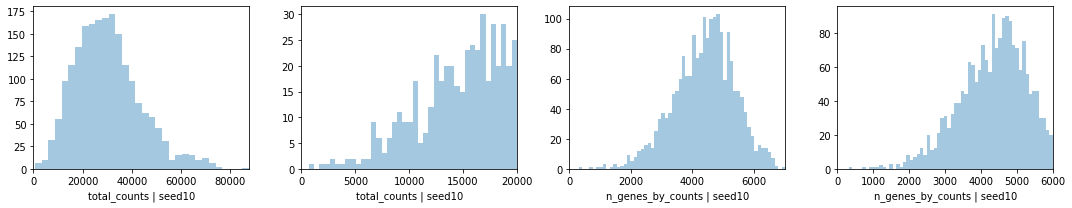

In [12]:
# PLOT QC FOR EACH SAMPLE 
if len(slides) > 2:
    figsize = 4*len(slides)-4
else:
    figsize = 4*len(slides)-1
    
fig, axs = plt.subplots(len(slides), 4, figsize=(15, figsize))
axs = axs.reshape((len(slides), 4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

In [13]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

In [14]:
import scipy
adata.X = scipy.sparse.csr_matrix(adata.X)

Select genes using expression in non-zero cells

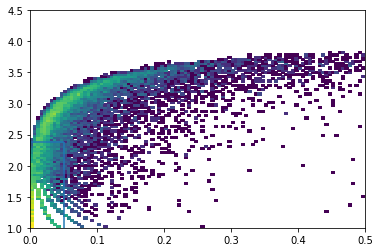

In [15]:
# Select cells
#min_genes = 1000  
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.001)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

In [16]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(8137, 12281)

In [17]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

In [18]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 8137 × 12281
    obs: 'annotation_1', 'n_genes'
    var: 'n_cells', 'nonz_mean'

Add counts matrix as `adata.raw` 

In [19]:
adata_snrna_raw.raw = adata_snrna_raw

In [20]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

#### Plot numbers of cells per spot

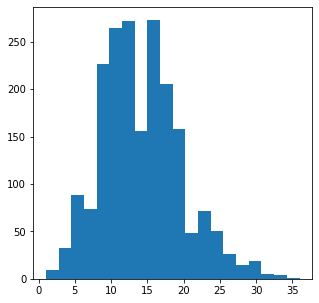

In [21]:
rcParams['figure.figsize'] = 5, 5
cell_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' not in i)
                               for i in adata.obs.columns]]
plt.hist(cell_count.sum(1), bins=20);

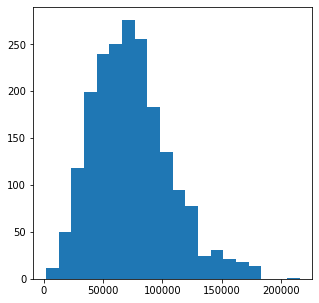

In [22]:
umi_count = adata.obs.loc[:, [('ref_' in i) & ('nUMI' in i)
                               for i in adata.obs.columns]]
plt.hist(umi_count.sum(1), bins=20);

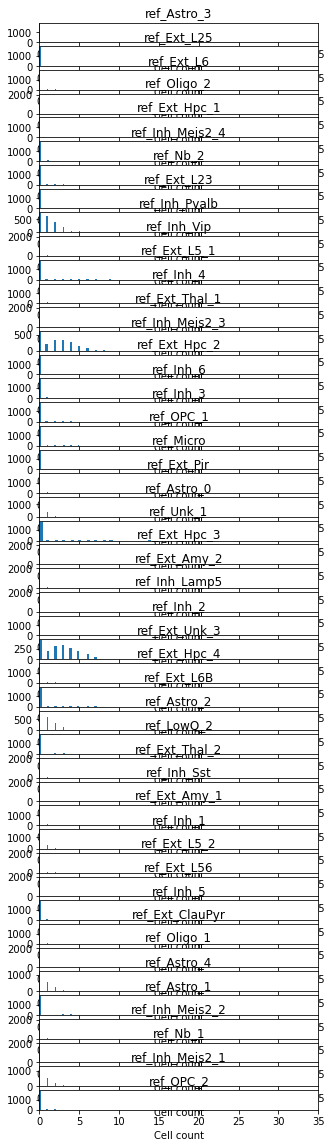

In [23]:
rcParams['figure.figsize'] = 5, 20
for i, c in enumerate(cell_count.columns):
    plt.subplot(cell_count.shape[1], 1, i+1)
    plt.hist(cell_count[c], bins = 35);
    plt.xlabel('Cell count');
    plt.xlim(0, 35);
    plt.title(str(c));
plt.tight_layout()

In [24]:
adata_vis.var['ENSEMBL'] = adata_vis.var_names
adata_vis.obs['sample'] = 'sample'

In [25]:
from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

### First, infer average expression in each cell type

In [26]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 8137 × 12281
    obs: 'annotation_1', 'n_genes', 'sample'
    var: 'n_cells', 'nonz_mean'

```python
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, 
                   model_name='RegressionNBV2Torch',
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['annotation_1'], 
                    'sample_name_col': 'sample',
                    'tech_id': None,
                    'stratify_cv': 'annotation_1',
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_average_as_initial_value': True, 'use_cuda': True,
                       
                    'train_proportion': 0.9,
                    'l2_weight': {'l2_weight': 0.001, 'sample_scaling_weight': 0.5,
                           'gene_overdisp_weight': 0.1},  # True = use defaults for the model
                    
                    'readable_var_name_col': None, 'use_raw': True},
                                 
                   model_kwargs={},
                   posterior_args={},
                                 
                   export_args={'path': results_folder + 'regression_model/', 'save_model': True,
                                'run_name_suffix': ''})

reg_mod = r['mod']
#adata_snrna_raw = r['sc_data']
```

In [27]:
reg_mod_name = 'RegressionNBV2Torch_48covariates_8137cells_12281genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']
r_reg = pickle.load(file = open(f'{reg_path}model_settings.p', "rb"))
r_reg

{'model_name': 'RegressionNBV2Torch',
 'train_args': {'covariate_col_names': ['annotation_1'],
  'sample_name_col': 'sample',
  'tech_name_col': None,
  'stratify_cv': 'annotation_1',
  'n_epochs': 100,
  'minibatch_size': 1024,
  'learning_rate': 0.01,
  'minibatch_seed': [41, 56, 345, 12, 6, 3],
  'use_average_as_initial_value': True,
  'use_cuda': True,
  'train_proportion': 0.9,
  'l2_weight': {'l2_weight': 0.001,
   'sample_scaling_weight': 0.5,
   'gene_overdisp_weight': 0.1},
  'sample_prior': False,
  'readable_var_name_col': None,
  'use_raw': True,
  'mode': 'normal',
  'n_type': 'restart',
  'n_restarts': 2,
  'tech_id': None},
 'posterior_args': {'n_samples': 1000,
  'evaluate_stability_align': False,
  'evaluate_stability_transpose': True,
  'mean_field_slot': 'init_1'},
 'export_args': {'path': '/nfs/team205/vk7/sanger_projects/cell2location/notebooks/results/lowdens_synthetic_ST_fewcells/samples_2/regression_model/',
  'plot_extension': 'png',
  'save_model': True,
  'ru

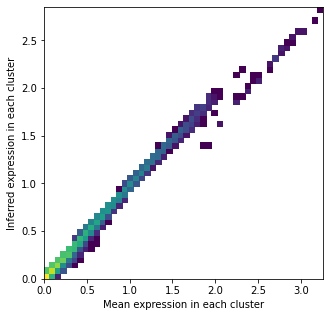

In [28]:
# export inferred averages in each cluster
inf_aver = pd.DataFrame(#adata_snrna_raw.uns['regression_mod']['post_sample_q05']['gene_factors'].T,
                        adata_snrna_raw.uns['regression_mod']['post_sample_means']['gene_factors'].T,
             index=adata_snrna_raw.uns['regression_mod']['var_names'], 
             columns=adata_snrna_raw.uns['regression_mod']['fact_names'])
inf_aver = inf_aver.loc[:, np.array(['annotation_1_' in i for i in inf_aver.columns])]
from re import sub
inf_aver.columns = [sub('annotation_1_', '', i) for i in inf_aver.columns]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# export inferred averages in each cluster
#inf_aver = reg_mod.covariate_effects.copy()
#from re import sub
#inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]
#inf_aver = inf_aver.loc[aver.index, aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

In [29]:
inf_aver

Astro_0   Astro_1   Astro_2   Astro_3       Astro_4  \
ENSMUSG00000051951  0.022486  0.016976  0.086153  0.041645  7.841317e-09   
ENSMUSG00000089699  0.003711  0.002256  0.007336  0.025868  3.093109e-02   
ENSMUSG00000033845  0.042481  0.072505  0.035373  0.079985  4.931773e-02   
ENSMUSG00000033813  0.111184  0.085064  0.109497  0.122533  2.128862e-02   
ENSMUSG00000002459  2.586503  0.938645  4.224512  1.497234  2.246430e+00   
...                      ...       ...       ...       ...           ...   
ENSMUSG00000064370  0.201819  0.076935  0.089152  0.005840  8.023349e-09   
ENSMUSG00000051412  0.031819  0.036382  0.015000  0.029460  7.998215e-09   
ENSMUSG00000079834  0.121683  0.189370  0.321544  0.277750  4.568088e-02   
ENSMUSG00000095041  0.188938  0.175850  0.194827  0.208523  5.072923e-02   
ENSMUSG00000063897  0.015431  0.033041  0.017138  0.063019  3.610925e-02   

                    Ext_Amy_1  Ext_Amy_2  Ext_ClauPyr  Ext_Hpc_1  Ext_Hpc_2  \
ENSMUSG00000051951  15.194770  12.538737     4.215148   7.860838  13.571537   
ENSMUSG00000089699   3.276940   2.852150     1.129400   1.778715   2.384050   
ENSMUSG00000033845   0.252719   0.201835     0.188274   0.144280   0.365312   
ENSMUSG00000033813   0.165481   0.164493     0.104745   0.165570   0.248927   
ENSMUSG00000002459   0.546757   0.562627     1.241626   0.123318   0.104664   
...                       ...        ...          ...        ...        ...   
ENSMUSG00000064370   0.348742   0.291074     0.315242   0.121683   0.110016   
ENSMUSG00000051412   0.015408   0.088058     0.023828   0.095689   0.138790   
ENSMUSG00000079834   0.300070   0.424299     0.371203   0.163733   0.465729   
ENSMUSG00000095041   1.711358   1.793614     2.606221   2.706197   2.911099   
ENSMUSG00000063897   0.076620   0.077367     0.073613   0.071130   0.041611   

                    ...   Inh_Vip    LowQ_2         Micro      Nb_1      Nb_2  \
ENSMUSG00000051951  ...  5.214285  4.136590  2.167259e-02  1.177524  0.209740   
ENSMUSG00000089699  ...  1.112758  1.197040  7.095898e-09  0.619586  0.104040   
ENSMUSG00000033845  ...  0.056814  0.044166  4.243574e-02  0.079114  0.064502   
ENSMUSG00000033813  ...  0.132924  0.271114  8.407845e-02  0.097186  0.029543   
ENSMUSG00000002459  ...  0.240054  0.057852  8.467723e-03  0.074956  0.299449   
...                 ...       ...       ...           ...       ...       ...   
ENSMUSG00000064370  ...  0.204742  0.168578  3.789560e-02  0.088139  0.029742   
ENSMUSG00000051412  ...  0.117163  0.013502  7.847074e-03  0.094277  0.048132   
ENSMUSG00000079834  ...  0.342700  0.113279  5.868919e-02  0.064777  0.025828   
ENSMUSG00000095041  ...  0.908492  1.756510  9.975887e-01  0.997305  0.207220   
ENSMUSG00000063897  ...  0.068936  0.031017  3.480173e-02  0.115953  0.030007   

                       OPC_1     OPC_2   Oligo_1   Oligo_2     Unk_1  
ENSMUSG00000051951  1.497111  0.490378  1.797966  0.580106  1.156588  
ENSMUSG00000089699  0.391304  0.073090  0.560728  0.135010  0.210410  
ENSMUSG00000033845  0.057116  0.038589  0.073402  0.054525  0.021059  
ENSMUSG00000033813  0.095502  0.099807  0.096890  0.049239  0.013652  
ENSMUSG00000002459  0.453870  0.098858  0.075901  0.006583  0.085499  
...                      ...       ...       ...       ...       ...  
ENSMUSG00000064370  0.111364  0.125249  0.025911  0.058576  0.014941  
ENSMUSG00000051412  0.042530  0.083835  0.092847  0.048933  0.003277  
ENSMUSG00000079834  0.147120  0.146925  0.167047  0.080244  0.058513  
ENSMUSG00000095041  0.322694  0.500456  0.174653  0.103910  0.115852  
ENSMUSG00000063897  0.047632  0.022309  0.031656  0.027520  0.007063  

[12281 rows x 46 columns]

rcParams['figure.figsize'] = 5, 5
reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

rcParams['figure.figsize'] = 5, 5
reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_average', 'inferred_average', align=False)

rcParams['figure.figsize'] = 5, 5
snrna_cell_count = adata_snrna_raw.obs['sample'].value_counts()
snrna_cell_count.index = ['mean_sample_effectsample_' + i for i in snrna_cell_count.index] 

soup_amount = reg_mod.sample_effects.sum(0) 
plt.scatter(snrna_cell_count[soup_amount.index].values.flatten(),
            soup_amount.values.flatten());
plt.xlabel('Cell count per sample'); # fraction of reads in cells
plt.ylabel('Inferred sum of sample effects');

In [30]:
def compare_oversipersion(shape, inferred_shape, aver, nrow=1, ncol=3):
    
    res = {}
    plt.subplot(nrow, ncol, 1)
    x = shape.max(1).values.flatten()
    res['max'] = x
    plt.hist2d(x, 
               inferred_shape.flatten(),
               bins=[35, 41], norm=matplotlib.colors.LogNorm());
    plt.xlabel('Analytic shape (max across clusters)');
    plt.ylabel('Inferred shape');
    plt.title('Overdispersion, cor: ' \
          + str(np.round(np.corrcoef(x, inferred_shape.flatten()), 3)[0,1]));
    
    plt.subplot(nrow, ncol, 2)
    x = shape.mean(1).values.flatten()
    res['mean'] = x
    plt.hist2d(x, 
               inferred_shape.flatten(),
               bins=[35, 41], norm=matplotlib.colors.LogNorm());
    plt.xlabel('Analytic shape (mean across clusters)');
    plt.ylabel('Inferred shape');
    plt.title('Overdispersion, cor: ' \
          + str(np.round(np.corrcoef(x, inferred_shape.flatten()), 3)[0,1]));
    
    plt.subplot(nrow, ncol, 3)
    max_ind = np.argmax(aver.values, axis=1)
    x = np.array([shape.values[i, max_ind[i]] for i in range(aver.shape[0])])
    res['max_mean'] = x
    plt.hist2d(x, 
               inferred_shape.flatten(),
               bins=[35, 41], norm=matplotlib.colors.LogNorm());
    plt.xlabel('Analytic shape (in cluster with max mean)');
    plt.ylabel('Inferred shape');
    plt.title('Overdispersion, cor: ' \
          + str(np.round(np.corrcoef(x, inferred_shape.flatten()), 3)[0,1]));
    
    return res

In [31]:
from cell2location.cluster_averages.cluster_averages import get_cluster_averages
from cell2location.cluster_averages.cluster_averages import get_cluster_variances
eps = 1e-8
aver = get_cluster_averages(adata_snrna_raw, 'annotation_1') + eps
variances = get_cluster_variances(adata_snrna_raw, 'annotation_1') + eps

shape = aver ** 2 / variances

## Model training

`pycell2location.run_cell2location` is a wrapper for cell2location model workflow:
We summarise single cell data, train the model, sample prior and posterior, save and export results, including diagnostic plots.

`pycell2location.run_cell2location` takes single cell and spatial anndata as input together with a bunch of parameters.

In [32]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/'

```python
rcParams['figure.figsize'] = 5, 5
from pycell2location.models.LocationModelLinearDependentW import LocationModelLinearDependentW
r = cell2location.run_cell2location(
                      sc_data=inf_aver,
                      sp_data=adata_vis,
                      model_name=LocationModelLinearDependentW,
                      verbose=True, return_all=True,
    
                      summ_sc_data_args={'cluster_col': "annotation_1"},
    
                      train_args={'n_iter': 30000, 'learning_rate': 0.005,
                                  'total_grad_norm_constraint': 200,
                                  'sample_prior': False, 'n_prior_samples': 20,
                                  'readable_var_name_col': "ENSEMBL",
                                  'sample_name_col': 'sample', 'method': 'advi'},
    
                      posterior_args={'n_samples': 500},
                      export_args={'path': results_folder + 'models/',
                                   'save_model': False, 'run_name_suffix': '_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01',
                                   'scanpy_coords_name': 'X_spatial', 'export_q05': True},
                      model_kwargs={
                                    'cell_number_prior': {'cells_per_spot': 9, 'factors_per_spot': 5, 
                                                          'combs_per_spot': 4
                                                         },
                                    'cell_number_var_prior': {
                                                   'cells_mean_var_ratio': 0.5,
                                                   'factors_mean_var_ratio': 1,
                                                   'combs_mean_var_ratio': 1
                                    },
                                    'gene_level_prior':{'mean': 1/2, 'sd': 1/4},
                                    'gene_level_var_prior': {'mean_var_ratio': 0.5},
                                    'n_comb': 60, 'spot_fact_mean_var_ratio': 5,
                                    'phi_hyp_prior':{'mean': 2, 'sd': 1}}
)

```

In [33]:
rcParams['figure.figsize'] = 5, 5
r = cell2location.run_cell2location(
                      sc_data=inf_aver,
                      sp_data=adata_vis,
                      #model_name=LocationModelLinearDependentW,
                      verbose=True, return_all=True,
    
                      summ_sc_data_args={'cluster_col': "annotation_1"},
    
                      train_args={'n_iter': 30000, 'learning_rate': 0.005,
                                  'total_grad_norm_constraint': 200,
                                  'sample_prior': False, 'n_prior_samples': 20,
                                  'readable_var_name_col': "ENSEMBL"},
    
                      posterior_args={'n_samples': 1000},
                      export_args={'path': results_folder,
                                   'save_model': False, 
                                   'run_name_suffix': '_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
                                   'scanpy_coords_name': 'X_spatial'},
                      model_kwargs={
                                    'cell_number_prior': {'cells_per_spot': 9, 'factors_per_spot': 5, 
                                                          'combs_per_spot': 4
                                                         },
                                    'gene_level_prior':{'mean': 1/2, 'sd': 1/4}
                      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModelLinearDependentW_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 2.3765e+07


Finished [100%]: Average Loss = 2.3764e+07



### Sampling posterior ### - time 19.24 min



### Saving results ###


... storing 'sample' as categorical


### Ploting results ###
### Plotting posterior of W / cell locations ###
### Done ### - time 20.43 min


In [33]:
from cell2location.models.LocationModel import LocationModel
rcParams['figure.figsize'] = 5, 5
r = cell2location.run_cell2location(
                      sc_data=inf_aver,
                      sp_data=adata_vis,
                      model_name=LocationModel,
                      verbose=True, return_all=True,
    
                      summ_sc_data_args={'cluster_col': "annotation_1"},
    
                      train_args={'n_iter': 30000, 'learning_rate': 0.005,
                                  'total_grad_norm_constraint': 200,
                                  'sample_prior': False, 'n_prior_samples': 20,
                                  'readable_var_name_col': "ENSEMBL"},
    
                      posterior_args={'n_samples': 1000},
                      export_args={'path': results_folder,
                                   'save_model': False, 
                                   'run_name_suffix': '_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
                                   'scanpy_coords_name': 'X_spatial'},
                      model_kwargs={
                                    'cell_number_prior': {'cells_per_spot': 9, 'factors_per_spot': 5
                                                         },
                                    'gene_level_prior':{'mean': 1/2, 'sd': 1/4}
                      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.01 min
### Analysis name: LocationModel_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2
### Training model ###


Finished [100%]: Average Loss = 2.3738e+07


Finished [100%]: Average Loss = 2.3738e+07



### Sampling posterior ### - time 18.93 min



### Saving results ###


... storing 'sample' as categorical


### Ploting results ###
### Plotting posterior of W / cell locations ###
### Done ### - time 19.89 min


## Evaluate inferred cell density (`spot_factors`) and mRNA count (`nUMI_factors`)

In [33]:
r_load = {'run_name': 'LocationModelLinearDependentW_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2'}
#r_load = {'run_name': 'LocationModel_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2'}

fig_path=results_folder +r_load['run_name']+'/plots'

sp_data_file = results_folder +r_load['run_name']+'/sp.h5ad'
adata_vis_res = anndata.read(sp_data_file)

In [35]:
file = results_folder + r_load['run_name']+'/model_.p'
r = pickle.load(file = open(file, "rb"))

In [36]:
# look at NBoverdispersion hyperprior
adata_vis_res.uns['mod']['post_sample_means']['phi_hyp']

array([[1.3488213]], dtype=float32)

In [37]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lowdens_synthetic_ST_fewcells/LocationModelLinearDependentW_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2/plots'

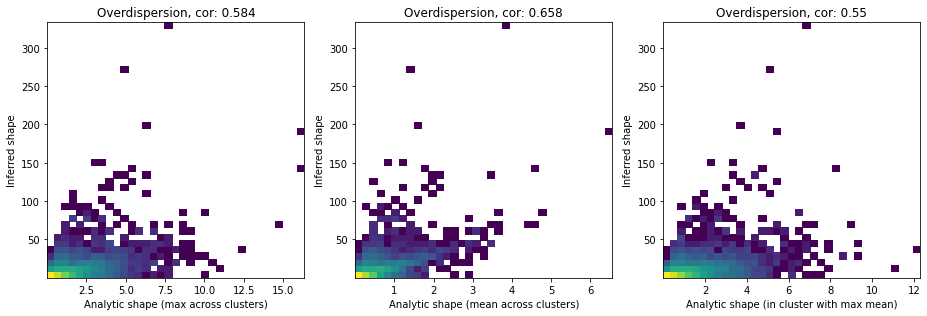

In [38]:
rcParams['figure.figsize'] = 13, 4.5
rcParams["axes.facecolor"] = "white"

inferred_shape = 1 / (adata_vis_res.uns['mod']['post_sample_means']['gene_E'] \
                      * adata_vis_res.uns['mod']['post_sample_means']['gene_E'])

compare_oversipersion(shape, inferred_shape, aver, nrow=1, ncol=3)
plt.tight_layout()

In [39]:
from re import sub
cell_count_columns = [sub('ref_', '', i) for i in cell_count.columns]

spot_factors = adata_vis_res.obs[['mean_spot_factors' + i for i in cell_count_columns]]
spot_factors.columns =  ['ref_' + sub('mean_spot_factors', '', i) for i in spot_factors.columns]

spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
spot_factors_sd.columns =  ['ref_' + sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

infer_cell_count = spot_factors[cell_count.columns]
#infer_cell_count = cells_per_factor[cell_count.columns]

nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
nUMI_factors.columns =  [sub('mean_nUMI_factors', 'ref_', i) for i in nUMI_factors.columns]

In [40]:
#spot_factors = spot_factors / spot_factors_sd

infer_cell_count = spot_factors[cell_count.columns]
infer_nUMI_count = nUMI_factors[cell_count.columns]

In [41]:
# mean number of cell types per location
(cell_count.values > 0).sum(1).mean(), (cell_count.values).sum(1).mean(),\
 (infer_cell_count.values > 1).sum(1).mean(), (infer_cell_count.values).sum(1).mean()

(6.252, 14.08, 1.85, 7.48140662012266)

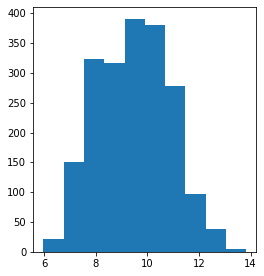

In [42]:
rcParams['figure.figsize'] = 4, 4.5
# look at the numberof cells per spot factors
plt.hist(adata_vis_res.uns['mod']['post_sample_means']['cells_per_spot']);

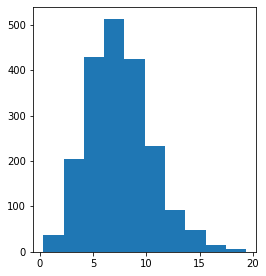

In [43]:
# look at the numberof expressed factors
plt.hist(spot_factors.sum(1));

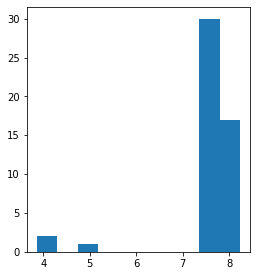

In [44]:
# look at the number of expressed factors
plt.hist(adata_vis_res.uns['mod']['post_sample_means']['factors_per_combs']);

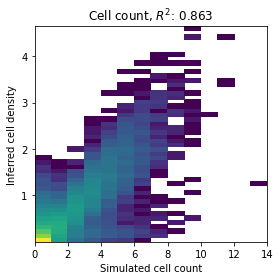

In [45]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           infer_cell_count.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[cell_count.values.max(), 50], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred cell density');
plt.title(r'Cell count, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_cell_count.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(fig_path + '/Cell_density_cor.pdf')

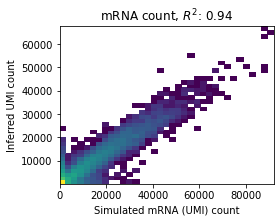

In [46]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(umi_count.values.flatten(), 
           nUMI_factors.values.flatten() \
           / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated mRNA (UMI) count');
plt.ylabel('Inferred UMI count');
plt.title('mRNA count, $R^2$: ' \
          + str(np.round(np.corrcoef(umi_count.values.flatten(), 
           nUMI_factors.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(fig_path + '/nUMI_count_cor.pdf')

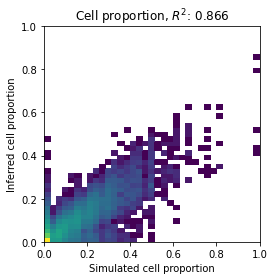

In [47]:
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_proportions.values.flatten(), 
           infer_cell_proportions.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportion');
plt.ylabel('Inferred cell proportion');
plt.title('Cell proportion, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           infer_cell_proportions.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout()
plt.savefig(fig_path + '/Cell_proportion_cor.pdf')

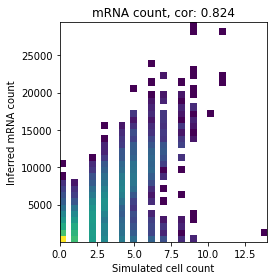

In [48]:
rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_count.values.flatten(), 
           infer_nUMI_count.values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred mRNA count');
plt.title('mRNA count, cor: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_nUMI_count.values.flatten()), 3)[0,1]));
plt.tight_layout();
#plt.savefig(fig_path + '/mRNA_count_cor.pdf')

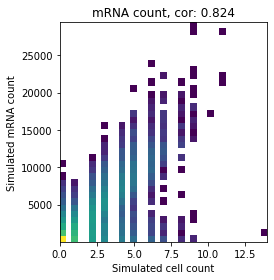

In [49]:
rcParams['figure.figsize'] = 4, 4
plt.hist2d(cell_count.values.flatten(), 
           nUMI_factors.values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Simulated mRNA count');
plt.title('mRNA count, cor: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           infer_nUMI_count.values.flatten()), 3)[0,1]));
plt.tight_layout();
#plt.savefig(fig_path + '/mRNA_count_cor.pdf')

In [50]:
def compute_precision_recall(pos_cell_count, infer_cell_proportions):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(pos_cell_count.ravel(),
                                                                    predictor.ravel())
    average_precision["micro"] = average_precision_score(pos_cell_count, predictor,
                                                         average="micro")
    
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                    infer_cell_proportions)
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["micro"], precision["micro"], color='navy', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append('Precision-recall for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.18), prop=dict(size=14))
    
    if save is not None:
        plt.savefig(save)

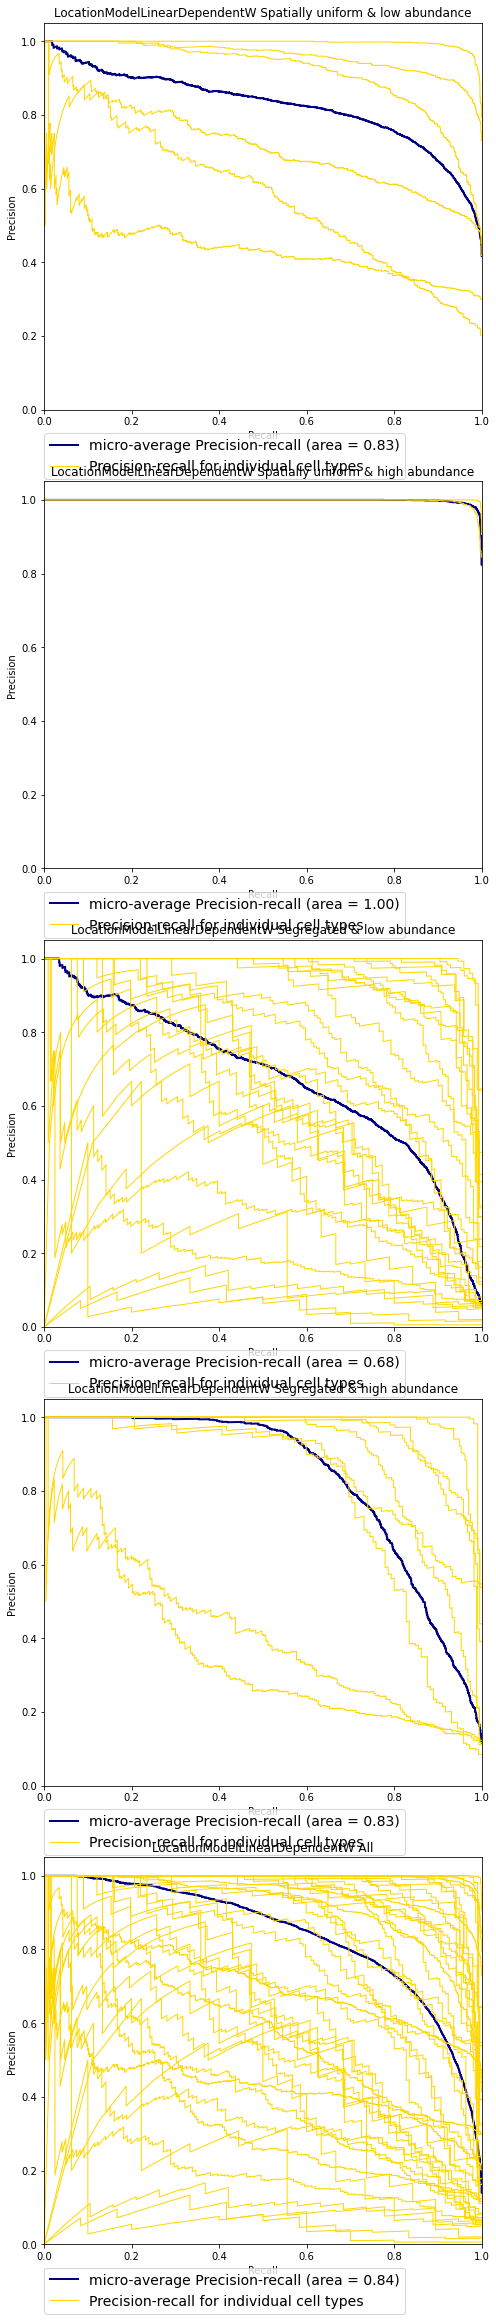

In [51]:
rcParams['figure.figsize'] = 7, 32
rcParams['pdf.fonttype'] = 42
pos_cell_count = cell_count.values > 0

def pr_by_category(pos_cell_count, infer_cell_count, design,
                   nrow=5, ncol=1, title='', fig_path=''):

    design_loc = design.loc[cell_count.columns,:]
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['uniform'] * design_loc['density']).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=title + ' Spatially uniform & low abundance',
                          #save=fig_path + '/Uniform_low_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['uniform'] * (1 - design_loc['density'])).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=title + ' Spatially uniform & high abundance',
                          #save=fig_path + '/Uniform_high_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['uniform']) * design_loc['density']).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=title + ' Segregated & low abundance',
                          #save=fig_path + '/Segregated_low_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['uniform']) * (1 - design_loc['density'])).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=title + ' Segregated & high abundance',
                          #save=fig_path + '/Segregated_high_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 5)
    plot_precision_recall(pos_cell_count, infer_cell_count,
                          title=title + ' All',
                          #save=fig_path + '/All.pdf'
                         )
    
from re import sub
model_name = sub('_.+$', '', r['run_name'])
pr_by_category(pos_cell_count, infer_cell_count, design,
               nrow=5, ncol=1, title=model_name,#r['model_name'],#.__name__,
               fig_path=fig_path)
plt.tight_layout()
plt.savefig(fig_path + '/All.pdf')

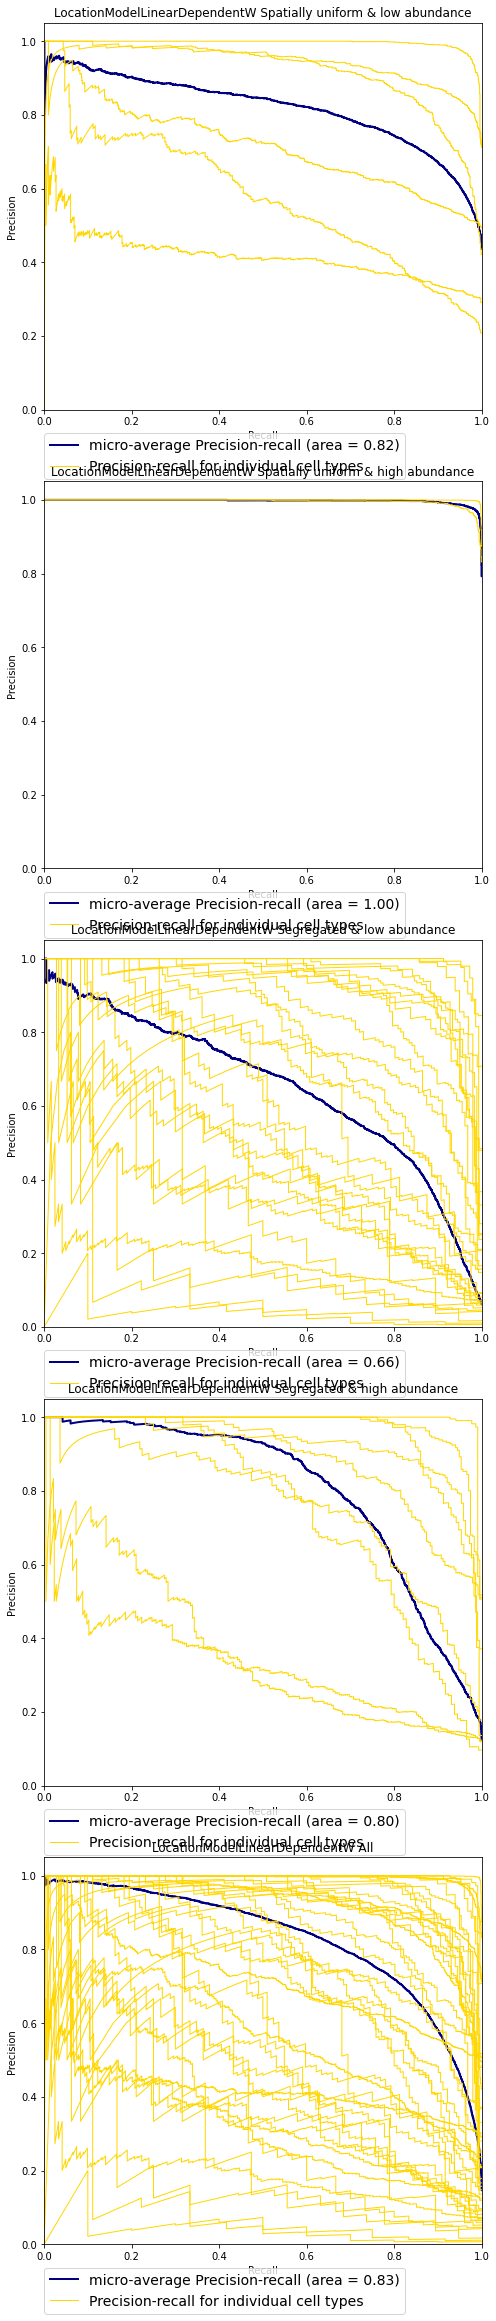

In [52]:
rcParams['figure.figsize'] = 7, 32
rcParams['pdf.fonttype'] = 42
pos_cell_count = cell_count.values > 0

pr_by_category(pos_cell_count, infer_cell_proportions, design,
               nrow=5, ncol=1, title=model_name,# r['model_name'],#.__name__,
               fig_path=fig_path)
plt.tight_layout()

#### Split results by spatial distribution and abundance of cell types

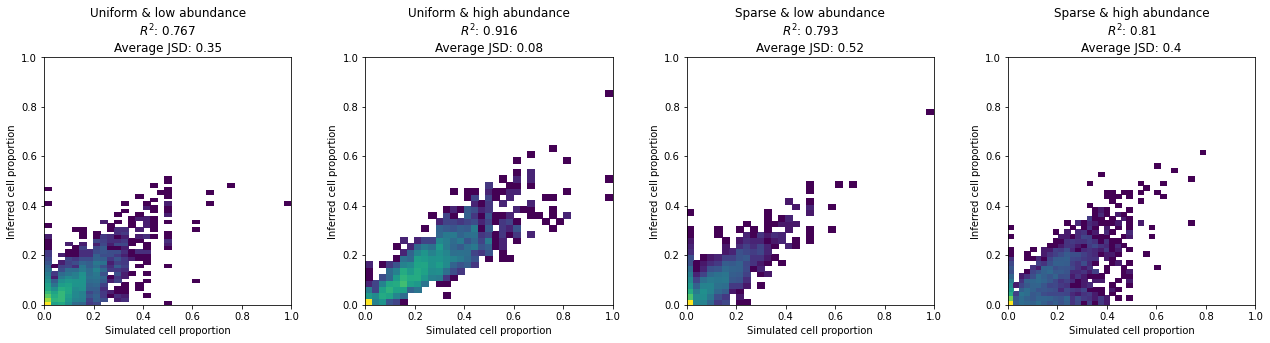

In [53]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True):
    
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    max_val = np.concatenate([cell_count.values.flatten(), 
                               infer_cell_count.values.flatten()]).max()
    title = title +'\n'+ r'$R^2$: ' + str(cor)
    
    if compute_kl:
        
        #kl = [KL(cell_count.values[r,:], infer_cell_count.values[r,:]) 
        #         for r in range(cell_count.shape[0])]
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        #kl = np.mean(kl)
        js = np.mean(js[~np.isnan(js)])
        #title = title + '\nAverage KL: ' + str(np.round(kl, 2))
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    if np.max(cell_count.values) > 1:
        x_bins = np.max(cell_count.values)
        max_val = None
    else:
        x_bins = 35
        max_val = 1
    
    plt.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[x_bins, 35], norm=matplotlib.colors.LogNorm());
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, max_val);
    plt.ylim(0, max_val);
    plt.title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['uniform'] * design_loc['density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Uniform & low abundance',
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['uniform'] * (1 - design_loc['density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Uniform & high abundance',
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['uniform']) * design_loc['density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Sparse & low abundance',
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['uniform']) * (1 - design_loc['density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='Sparse & high abundance',
                 compute_kl=compute_kl, equal=equal)
    
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_proportions, infer_cell_proportions, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 #compute_kl=False, 
                 nrow=1, ncol=4, equal=True)
plt.tight_layout()

plt.savefig(fig_path + '/hist_by_category.pdf')

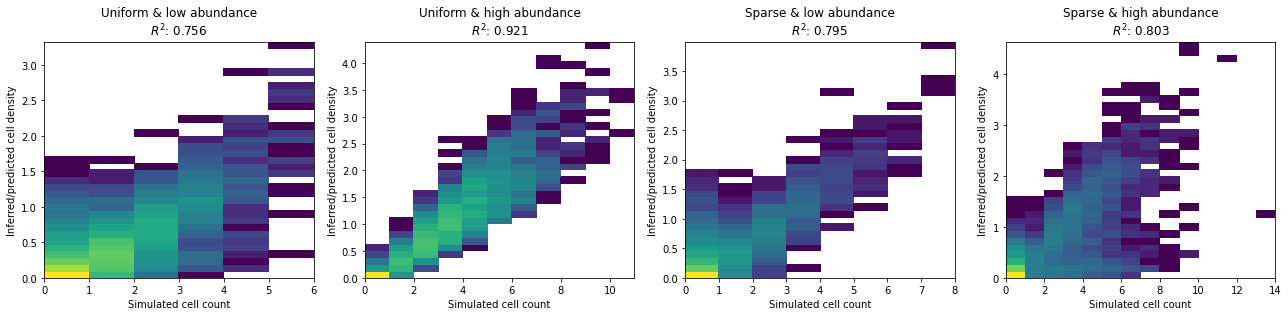

In [54]:
rcParams['figure.figsize'] = 18, 4.5
rcParams["axes.facecolor"] = "white"
hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell count',
                 ylab='Inferred/predicted cell density',
                 compute_kl=False, equal=False)
plt.tight_layout()
plt.savefig(fig_path + '/hist_density_by_category.pdf')

plt.hist(adata_vis_res.uns['mod']['post_sample_means']['factors_per_spot'].flatten());

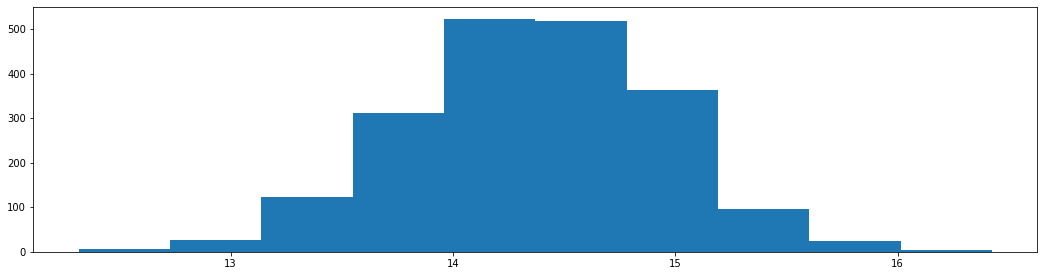

In [55]:
plt.hist(adata_vis_res.uns['mod']['post_sample_means']['combs_per_spot'].flatten());

In [56]:
combs_factors_df = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['combs_factors'],
                            columns=['comb_' + str(i) for i in range(adata_vis_res.uns['mod']['post_sample_means']['combs_factors'].shape[1])])
combs_factors_df

comb_0    comb_1    comb_2    comb_3    comb_4    comb_5    comb_6  \
0     0.137800  0.138623  0.155795  0.147254  0.118412  0.114894  0.115539   
1     0.179034  0.200879  0.242255  0.198381  0.285723  0.165343  0.228174   
2     0.244954  0.236823  0.221590  0.228491  0.202933  0.180494  0.164347   
3     0.156309  0.213116  0.222097  0.134368  0.182690  0.184680  0.136483   
4     0.133662  0.165300  0.227124  0.118542  0.220541  0.149870  0.135701   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.193875  0.228676  0.282544  0.187031  0.283635  0.223698  0.239968   
1996  0.115434  0.153299  0.157869  0.127714  0.132883  0.104657  0.122353   
1997  0.193043  0.221198  0.326047  0.261116  0.354197  0.457710  0.205955   
1998  0.197151  0.146726  0.182610  0.136569  0.191020  0.130417  0.147930   
1999  0.137735  0.138250  0.201723  0.303314  0.211245  0.216377  0.203662   

        comb_7    comb_8    comb_9  ...   comb_40   comb_41   comb_42  \
0     0.119604  0.203108  0.176188  ...  0.067150  0.151050  0.170574   
1     0.237921  0.143173  0.310503  ...  0.224324  0.267590  0.200004   
2     0.174686  0.209903  0.177479  ...  0.341612  0.168971  0.240713   
3     0.131837  0.152746  0.173563  ...  0.223406  0.189529  0.127601   
4     0.144981  0.250796  0.194329  ...  0.250890  0.159592  0.123670   
...        ...       ...       ...  ...       ...       ...       ...   
1995  0.260659  0.266577  0.196317  ...  0.224561  0.326270  0.277653   
1996  0.110147  0.153182  0.111919  ...  0.335983  0.180317  0.172383   
1997  0.221336  0.367521  0.302760  ...  0.048119  0.180224  0.221116   
1998  0.111064  0.174534  0.186283  ...  0.004959  0.116476  0.214606   
1999  0.280958  0.312071  0.271363  ...  0.044874  0.234058  0.212299   

       comb_43   comb_44   comb_45   comb_46   comb_47   comb_48   comb_49  
0     0.152823  0.173935  0.180079  0.132417  0.136647  0.151169  0.170162  
1     0.251886  0.326789  0.201756  0.230754  0.193749  0.199193  0.248954  
2     0.160824  0.209659  0.219536  0.199023  0.236324  0.261660  0.283022  
3     0.134569  0.157332  0.140787  0.203795  0.115955  0.176656  0.175453  
4     0.184147  0.147178  0.156799  0.184584  0.160446  0.187144  0.138781  
...        ...       ...       ...       ...       ...       ...       ...  
1995  0.156774  0.275054  0.213139  0.234468  0.265299  0.253002  0.175780  
1996  0.162933  0.101050  0.110747  0.177133  0.106136  0.153345  0.139140  
1997  0.373290  0.156298  0.289053  0.298937  0.201494  0.309072  0.245986  
1998  0.144075  0.122329  0.145755  0.166945  0.190090  0.136009  0.136125  
1999  0.163585  0.137983  0.116336  0.184473  0.253636  0.186902  0.213015  

[2000 rows x 50 columns]

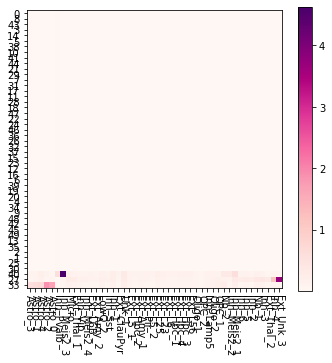

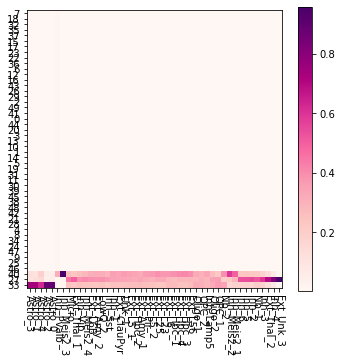

In [57]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis_res.uns['mod']['fact_names'])
comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df)
clustermap(comb2fact_df_prop)

#### Stratify cell types by their size in the reference

In [58]:
gene_factors = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['gene_factors'],
                            index=adata_vis_res.uns['mod']['var_names'],
                            columns=adata_vis_res.uns['mod']['fact_names'])

Index(['Astro_0', 'Astro_1', 'Astro_2', 'Astro_3', 'Astro_4', 'Micro', 'Nb_1',
       'Nb_2', 'Oligo_2', 'Unk_1'],
      dtype='object')

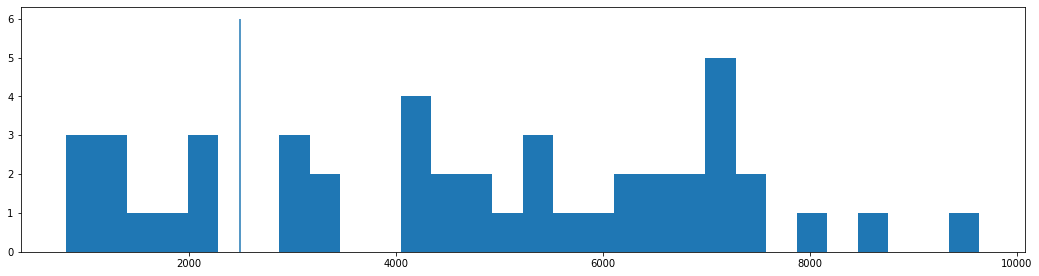

In [59]:
plt.hist(gene_factors.sum(0), bins=30);
plt.vlines(2500, 0, 6);
small_ind = np.array(gene_factors.sum(0) < 2500) & (design['density']).values.astype(bool)
gene_factors.columns[small_ind]

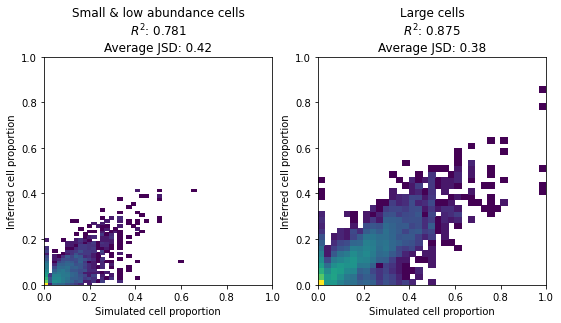

In [60]:
def hist_by_category2(cell_count, infer_cell_count, index,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='', name2='',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    plt.subplot(nrow, ncol, 1)
    hist_obs_sim(cell_count.loc[:,index], infer_cell_count.loc[:,index.astype(bool)],
                 xlab=xlab,
                 ylab=ylab,
                 title=name1,
                 compute_kl=compute_kl, equal=equal)
    
    plt.subplot(nrow, ncol, 2)
    hist_obs_sim(cell_count.loc[:,~index], infer_cell_count.loc[:,~index.astype(bool)],
                 xlab=xlab,
                 ylab=ylab,
                 title=name2,
                 compute_kl=compute_kl, equal=equal)
    
rcParams['figure.figsize'] = 9, 4.5
rcParams["axes.facecolor"] = "white"

hist_by_category2(cell_proportions, infer_cell_proportions, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

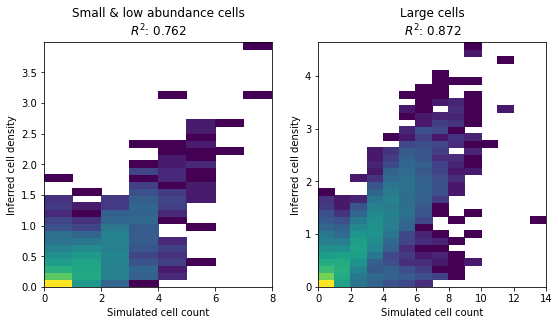

In [61]:
hist_by_category2(cell_count, infer_cell_count, small_ind,
                 xlab='Simulated cell count',
                 ylab='Inferred cell density',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=False, equal=False)

### Evaluate inferred gene expression level difference between technologies (`gene_level`)

In [62]:
gene_level = pd.DataFrame(adata_vis_res.uns['mod']['post_sample_means']['gene_level'].flatten(),
                 index=adata_vis_res.uns['mod']['var_names'],
                 columns=['inferred_gene_level'])
adata_vis_res.var['inferred_gene_level'] = gene_level.reindex(index=adata_vis_res.var_names)['inferred_gene_level']

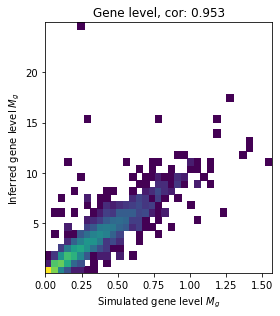

In [63]:
rcParams['figure.figsize'] = 4, 4.5
var = adata_vis_res.var
var = var.loc[~var['inferred_gene_level'].isna(),:]
plt.hist2d(var['gene_level'].values.flatten() / 5, 
           var['inferred_gene_level'].values.flatten(),
           bins=35, norm=matplotlib.colors.LogNorm());
plt.xlabel(r'Simulated gene level $M_g$');
plt.ylabel('Inferred gene level $M_g$');
#plt.xlim(0, 1);
#plt.ylim(0, 1);
plt.title('Gene level, cor: ' \
          + str(np.round(np.corrcoef(var['gene_level'].values.flatten(), 
                var['inferred_gene_level'].values.flatten()), 3)[0,1]));
plt.tight_layout();
plt.savefig(fig_path + '/hist_gene_level.pdf')

### Evaluate inferred cell density inferred with stereoscope

In [74]:
# read cell proportions
stereo_path_1 = results_folder + 'stereoscope/run_sp_data_downsampled/sp_data_downsampled/W.2020-07-03143613.779408.tsv'

stereo_df = pd.read_csv(stereo_path_1, sep='\t', index_col=0)

adata_vis_plt = adata_vis.copy()
stereo_df = stereo_df.loc[stereo_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[stereo_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [75]:
# Check that stereoscope and cell2location are evaluated on the same data. If not - stop!
data_csv = pd.read_csv('/lustre/scratch117/cellgen/team283/vk7/data_sharing/visium/lowdens_synthetic_ST_fewcells/csv_export/seed10/sp_data_downsampled.tsv',
                       sep='\t', index_col='spot')
data_csv_mat = data_csv.loc[adata_vis_plt.raw.obs_names, adata_vis_plt.raw.var_names].values

if (adata_vis_plt.raw.X == data_csv_mat).mean() != 1:
    raise ValueError('stereoscope and cell2location are evaluated on different data')

In [76]:
stereo_df.columns = ['ref_' + i for i in stereo_df.columns]
stereo_df = stereo_df[cell_count.columns]

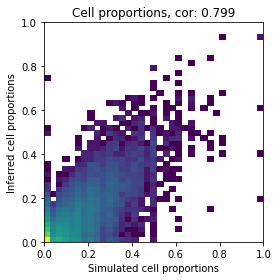

In [77]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           stereo_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           stereo_df.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout();

plt.savefig(os.path.split(stereo_path_1)[0] + '/Cell_proportion_cor.pdf')

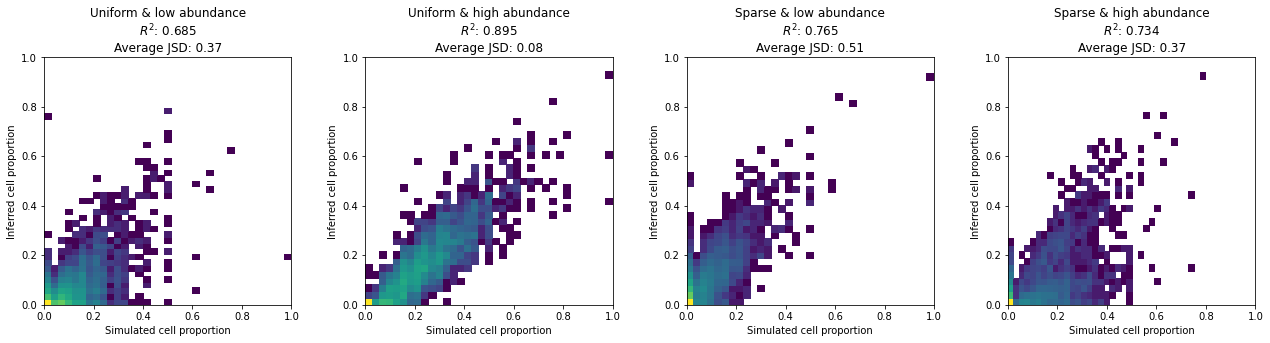

In [78]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, stereo_df, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(stereo_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

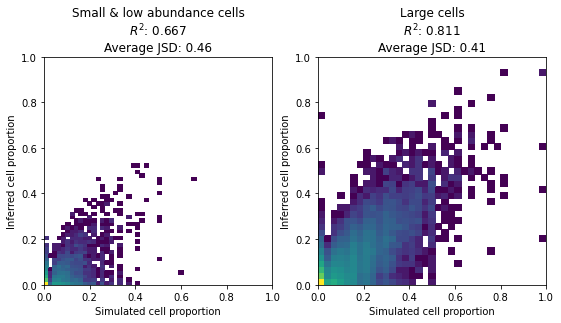

In [79]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, stereo_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(stereo_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

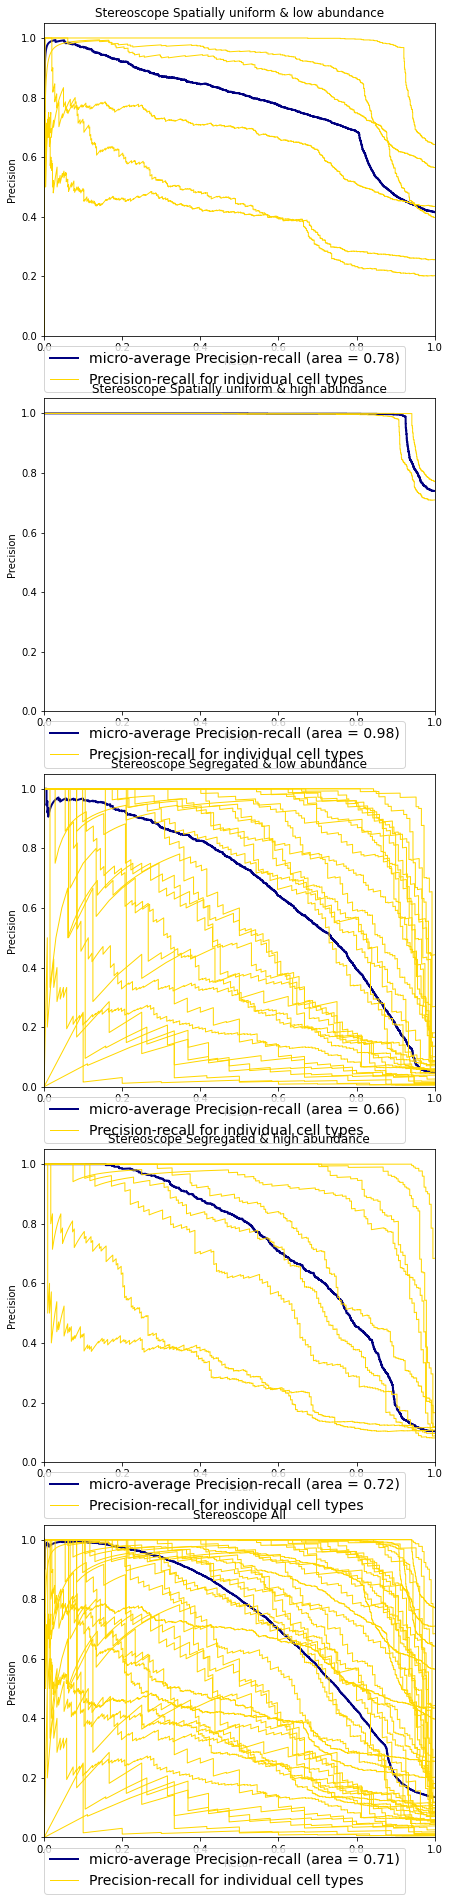

In [80]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0
pr_by_category(pos_cell_count, stereo_df, design,
                 nrow=5, ncol=1,
                      title='Stereoscope')

plt.savefig(os.path.split(stereo_path_1)[0] + '/ROC_all.pdf')

### Evaluate inferred cell density inferred with nnls (autogenes)

In [81]:
# read cell proportions
nnls_path_1 = results_folder + 'autogenes_models/coef_nnls_seed' + seed_numbers + '.csv'
nnls_df = pd.read_csv(nnls_path_1, sep=',', index_col=0).T

# compute proportions per location
nnls_df = (nnls_df.T / nnls_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
nnls_df = nnls_df.loc[nnls_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[nnls_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [82]:
nnls_df.columns = ['ref_' + i for i in nnls_df.columns]
nnls_df = nnls_df[cell_count.columns]

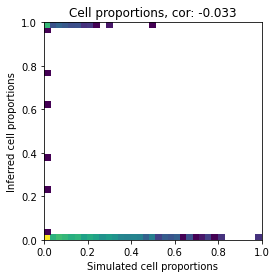

In [83]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           nnls_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           nnls_df.values.flatten()), 3)[0,1]));

plt.savefig(os.path.split(nnls_path_1)[0] + '/Cell_proportion_cor.pdf')

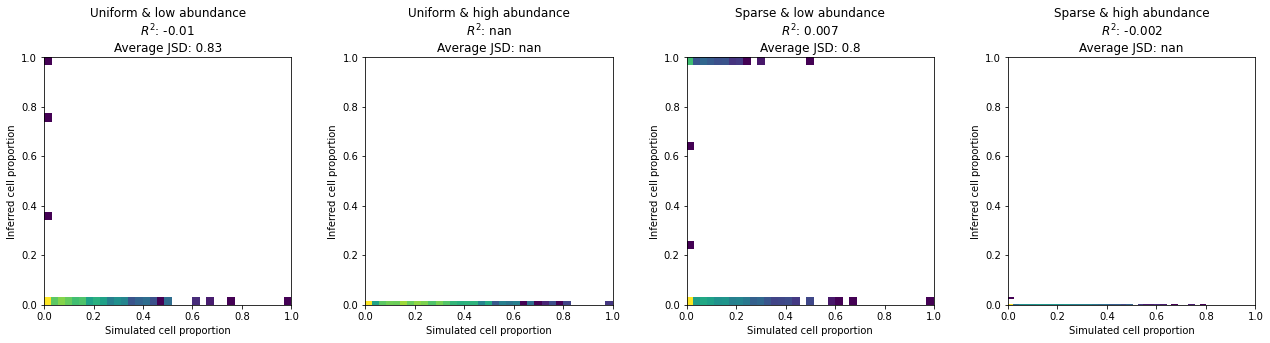

In [84]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, nnls_df, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(nnls_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

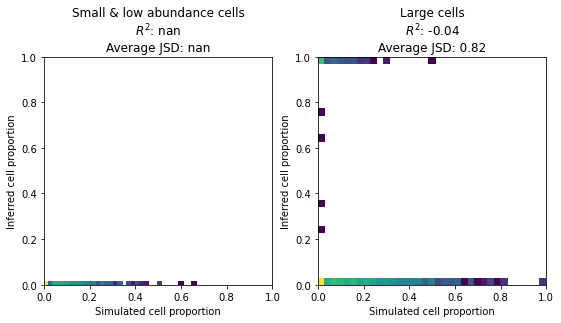

In [85]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, nnls_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(nnls_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

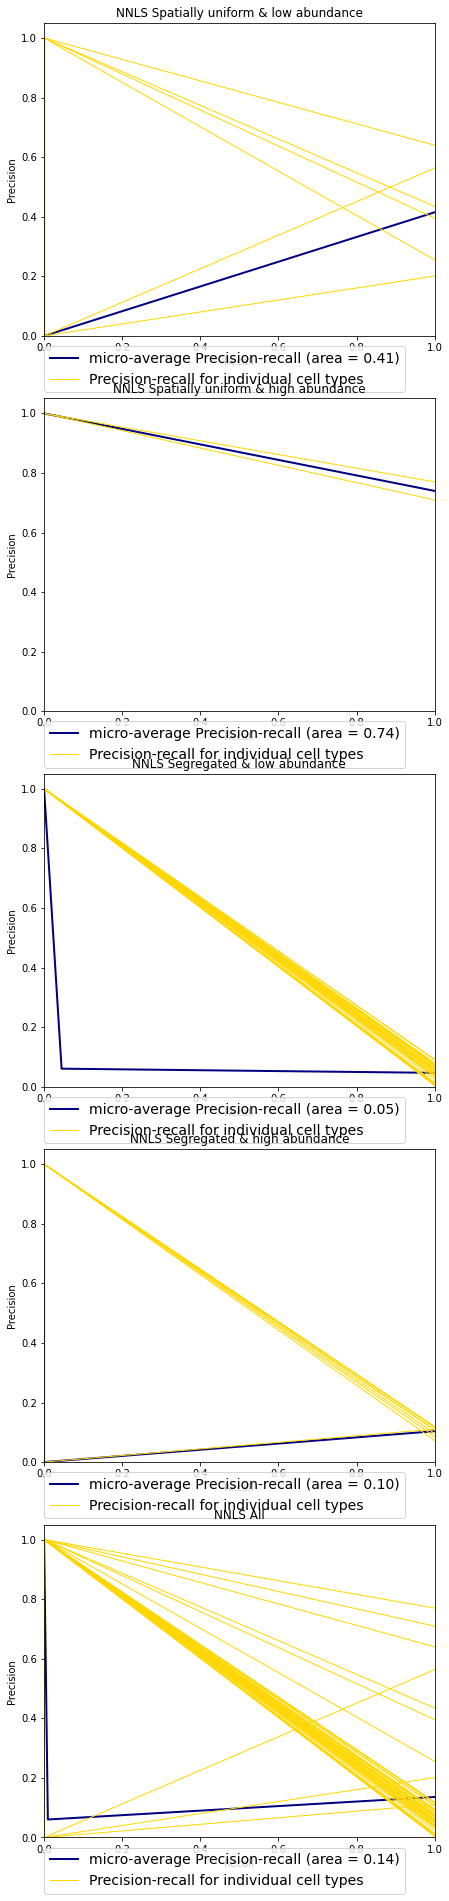

In [86]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0
pr_by_category(pos_cell_count, nnls_df, design,
                 nrow=5, ncol=1,
                      title='NNLS')

plt.savefig(os.path.split(nnls_path_1)[0] + '/ROC_all.pdf')

### Evaluate inferred cell density inferred with RCTD

In [87]:
# read cell proportions
RCTD_path_1 = results_folder + 'rctd/results_weights' + seed_numbers + '.csv'
RCTD_df = pd.read_csv(RCTD_path_1, sep=',', index_col='spot')

# compute proportions per location
RCTD_df_orig = RCTD_df.copy()
RCTD_df = (RCTD_df.T / RCTD_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
RCTD_df = RCTD_df.loc[RCTD_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[RCTD_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [88]:
RCTD_df.columns = ['ref_' + i for i in RCTD_df.columns]
RCTD_df = RCTD_df[cell_count.columns]
RCTD_df_orig.columns = ['ref_' + i for i in RCTD_df_orig.columns]
RCTD_df_orig = RCTD_df_orig[cell_count.columns]

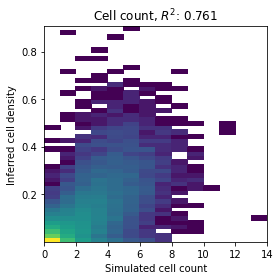

In [89]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_count.values.flatten(), 
           RCTD_df_orig.values.flatten(),# / np.mean(adata_vis_res.var['gene_level'].values),
           bins=[cell_count.values.max(), 50], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell count');
plt.ylabel('Inferred cell density');
plt.title(r'Cell count, $R^2$: ' \
          + str(np.round(np.corrcoef(cell_count.values.flatten(), 
           RCTD_df_orig.values.flatten()), 3)[0,1]));
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(os.path.split(RCTD_path_1)[0] + '/RCTD_Cell_density_cor.pdf')

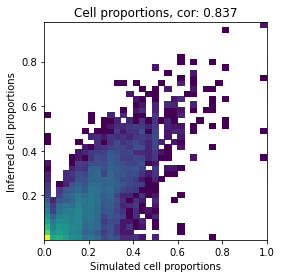

In [90]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           RCTD_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           RCTD_df.values.flatten()), 3)[0,1]));

plt.savefig(os.path.split(RCTD_path_1)[0] + '/Cell_proportion_cor.pdf')

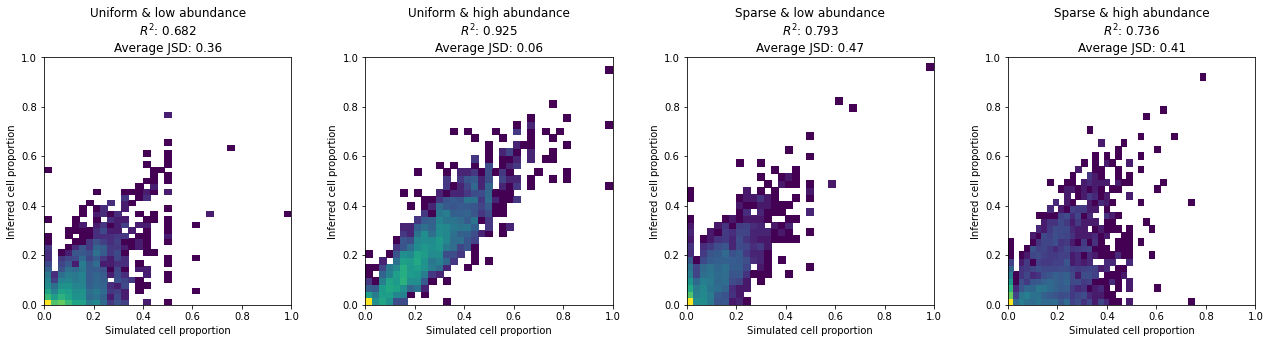

In [91]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, RCTD_df, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(RCTD_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

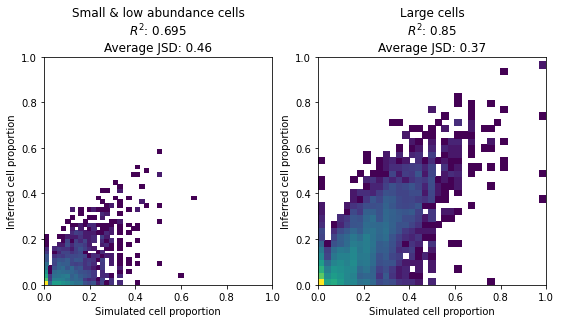

In [92]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, RCTD_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(RCTD_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

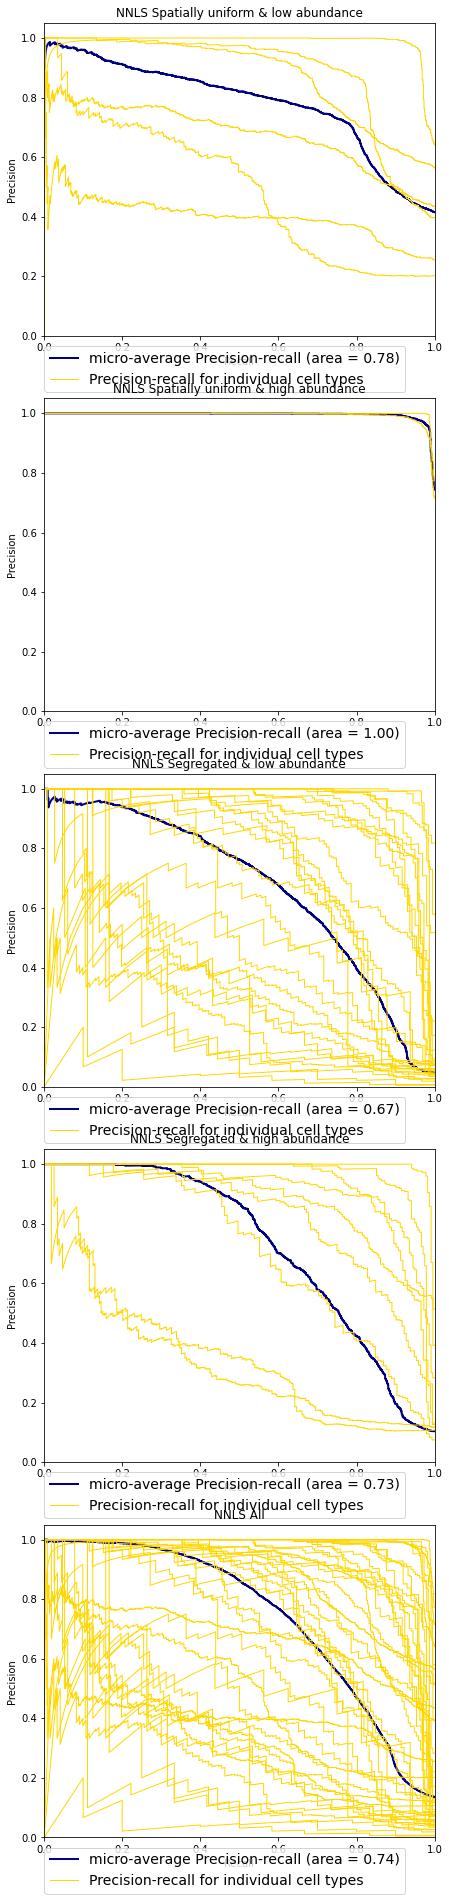

In [93]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0
pr_by_category(pos_cell_count, RCTD_df, design,
                 nrow=5, ncol=1,
                      title='NNLS')

plt.savefig(os.path.split(RCTD_path_1)[0] + '/ROC_all.pdf')

### Evaluate inferred cell propotion inferred with Seurat 3

In [94]:
# read cell proportions
seurat_path_1 = results_folder + 'seurat/dowsampled_seurat_pca_seed' + seed_numbers + '.csv'
seurat_df = pd.read_csv(seurat_path_1, sep=',', index_col='spot')
seurat_df = seurat_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
from re import sub
seurat_df.columns = [sub('prediction.score.', '', i) for i in seurat_df.columns]

# compute proportions per location
seurat_df = (seurat_df.T / seurat_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
seurat_df = seurat_df.loc[seurat_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[seurat_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [95]:
seurat_df.columns = ['ref_' + i for i in seurat_df.columns]
seurat_df = seurat_df[cell_count.columns]

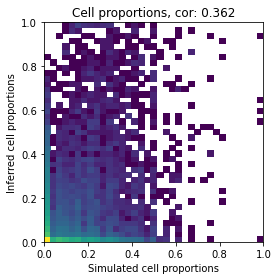

In [96]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           seurat_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           seurat_df.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout();

plt.savefig(os.path.split(seurat_path_1)[0] + '/Cell_proportion_cor.pdf')

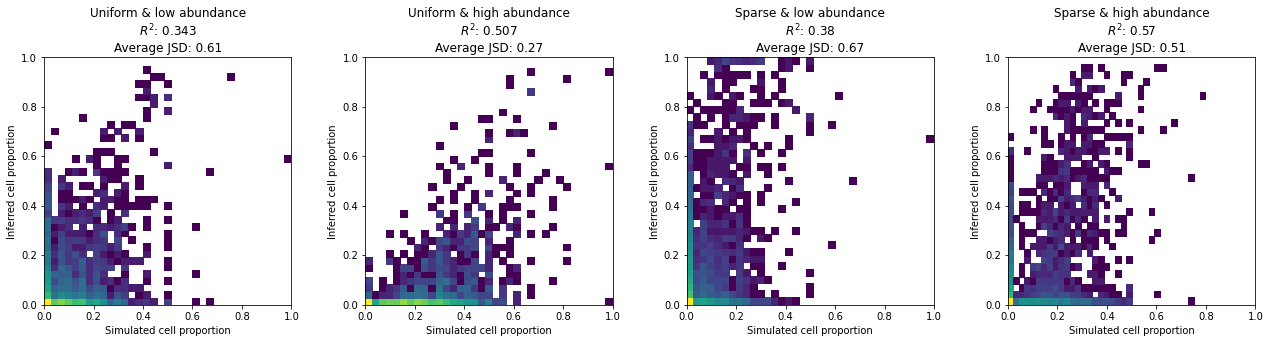

In [97]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, seurat_df, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(seurat_path_1)[0] + '/Cell_proportion_cor_by_group.pdf')

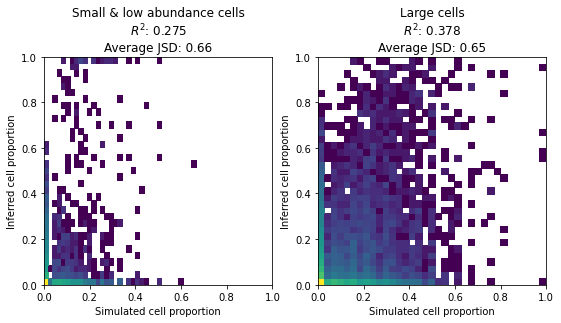

In [98]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, seurat_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(seurat_path_1)[0] + '/Cell_proportion_cor_by_size.pdf')

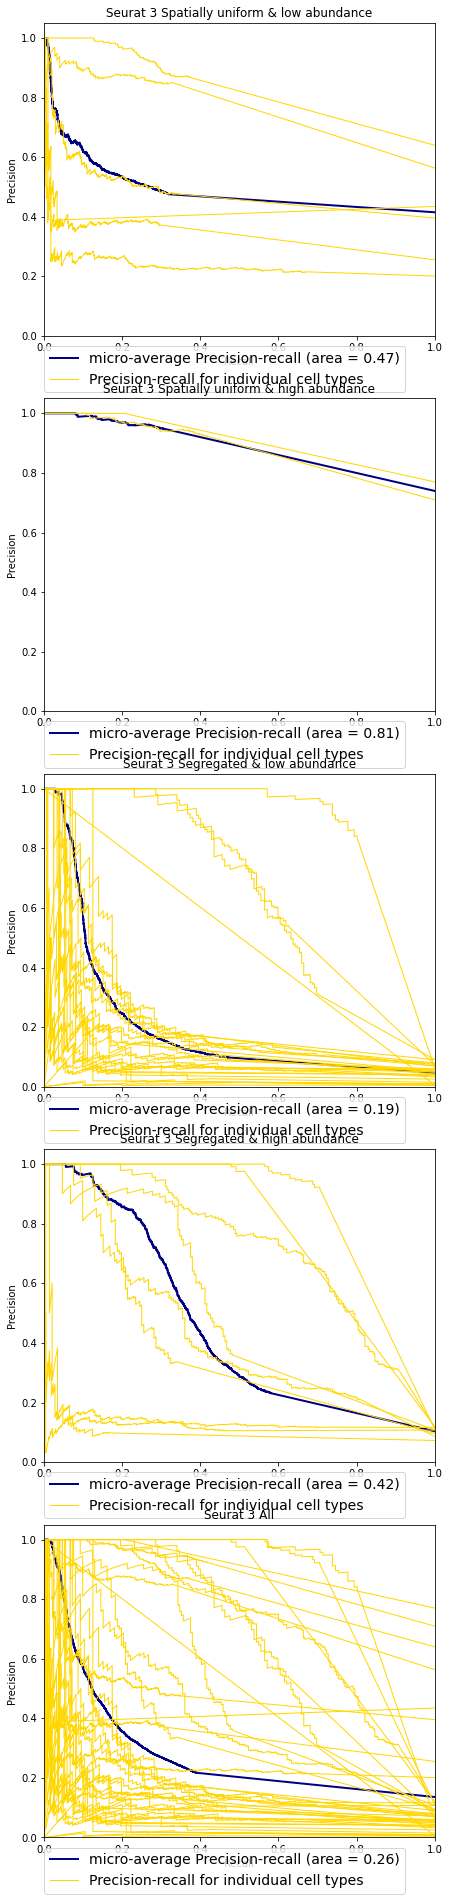

In [99]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0
pr_by_category(pos_cell_count, seurat_df, design,
                 nrow=5, ncol=1,
                      title='Seurat 3',
               fig_path=fig_path)

plt.savefig(os.path.split(seurat_path_1)[0] + '/ROC_all.pdf')

In [100]:
# read cell proportions
seurat_path_1 = results_folder + 'seurat/dowsampled_seurat_cca_seed' + seed_numbers + '.csv'
seurat_cca_df = pd.read_csv(seurat_path_1, sep=',', index_col='spot')
seurat_cca_df = seurat_cca_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
from re import sub
seurat_cca_df.columns = [sub('prediction.score.', '', i) for i in seurat_cca_df.columns]

# compute proportions per location
seurat_cca_df = (seurat_cca_df.T / seurat_cca_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
seurat_cca_df = seurat_cca_df.loc[seurat_cca_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[seurat_cca_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [101]:
seurat_cca_df.columns = ['ref_' + i for i in seurat_cca_df.columns]
seurat_cca_df = seurat_cca_df[cell_count.columns]

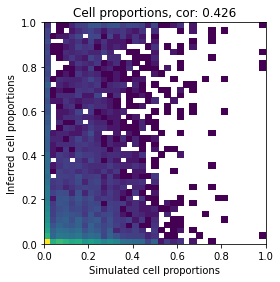

In [102]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           seurat_cca_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           seurat_cca_df.values.flatten()), 3)[0,1]));
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.tight_layout();

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_Cell_proportion_cor.pdf')

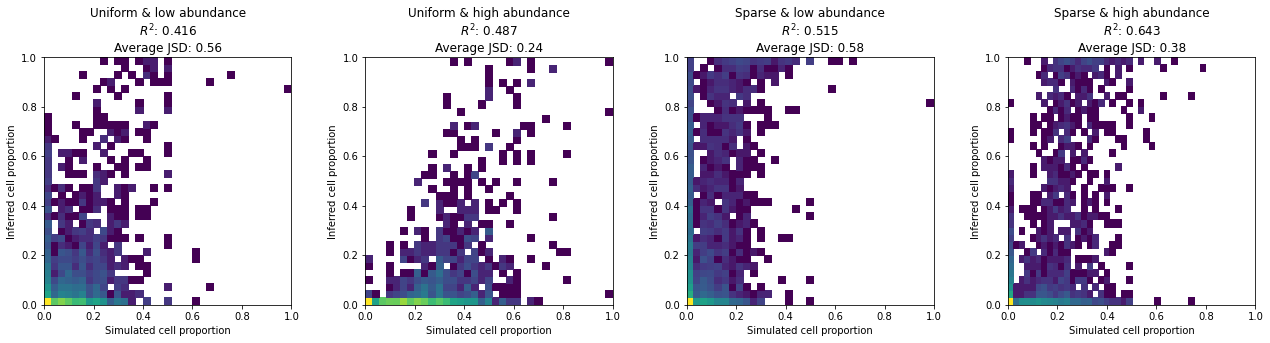

In [103]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, seurat_cca_df, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_Cell_proportion_cor_by_group.pdf')

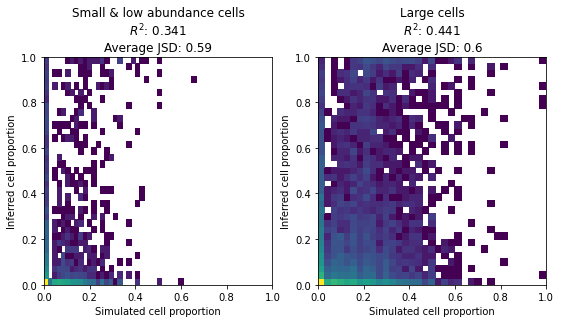

In [104]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, seurat_cca_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_Cell_proportion_cor_by_size.pdf')

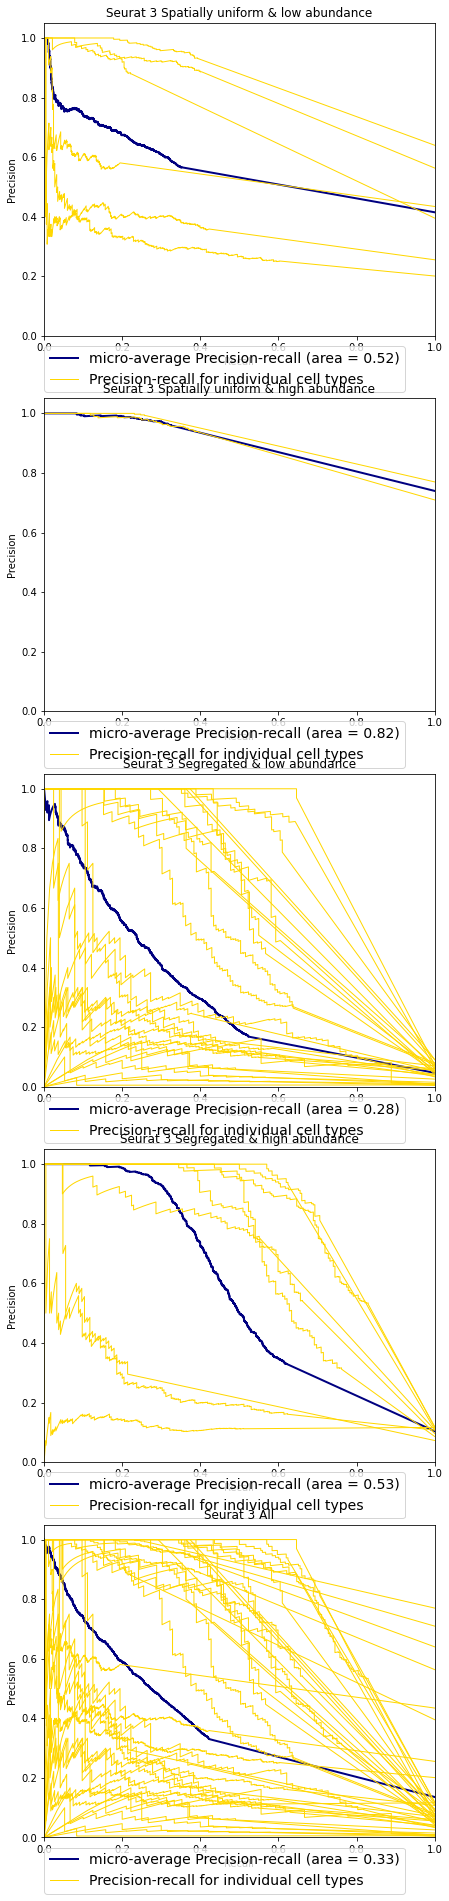

In [105]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0
pr_by_category(pos_cell_count, seurat_cca_df, design,
                 nrow=5, ncol=1,
                      title='Seurat 3',
               fig_path=fig_path)

plt.savefig(os.path.split(seurat_path_1)[0] + '/cca_ROC_all.pdf')

### Evaluate inferred cell propotion inferred with SPOTlight

In [106]:
# read cell proportions
spotlight_path_1 = results_folder + 'seurat/dowsampled_spotlight_seed' + seed_numbers + '.csv'
spotlight_df = pd.read_csv(spotlight_path_1, sep=',', index_col='rn')
spotlight_df = spotlight_df.drop(columns=['res_ss'])

# compute proportions per location (already proportions)
#spotlight_df = (spotlight_df.T / spotlight_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
spotlight_df = spotlight_df.loc[spotlight_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[spotlight_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]

Trying to set attribute `.obs` of view, copying.


In [107]:
spotlight_df.columns = ['ref_' + i for i in spotlight_df.columns]
spotlight_df = spotlight_df[cell_count.columns]

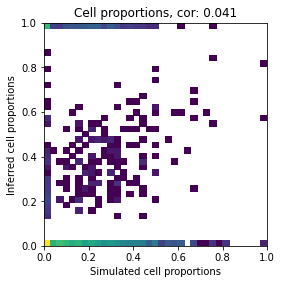

In [108]:
rcParams['figure.figsize'] = 4, 4.5
rcParams["axes.facecolor"] = "white"

plt.hist2d(cell_proportions.values.flatten(), 
           spotlight_df.values.flatten(),
           bins=[35, 41], norm=matplotlib.colors.LogNorm());
plt.xlabel('Simulated cell proportions');
plt.ylabel('Inferred cell proportions');
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Cell proportions, cor: ' \
          + str(np.round(np.corrcoef(cell_proportions.values.flatten(), 
           spotlight_df.values.flatten()), 3)[0,1]));

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightCell_proportion_cor.pdf')

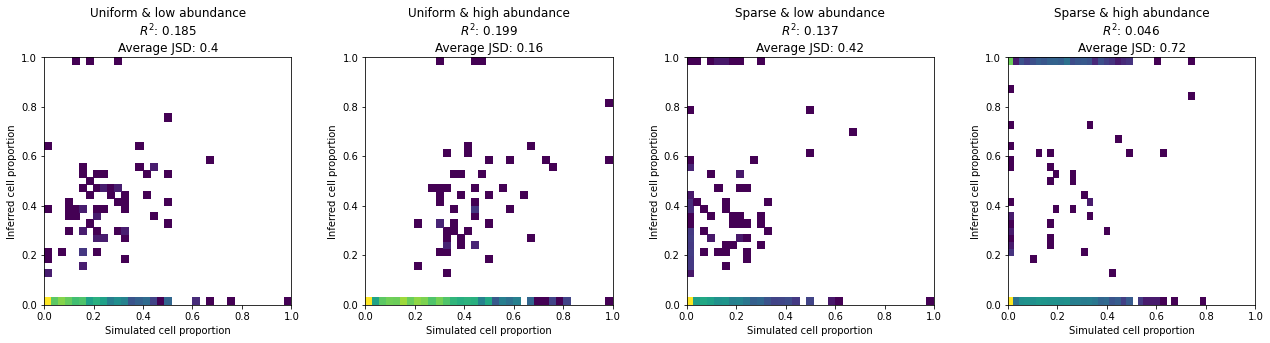

In [109]:
rcParams['figure.figsize'] = 18, 4.5
hist_by_category(cell_proportions, spotlight_df, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion')
plt.tight_layout()

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightCell_proportion_cor_by_group.pdf')

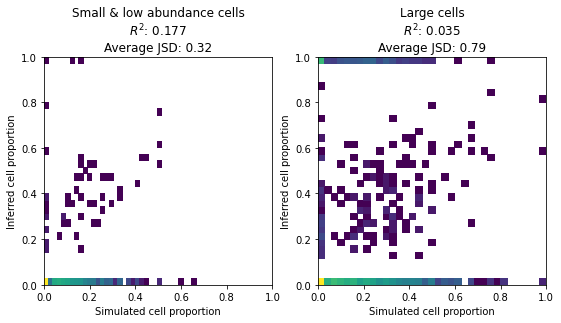

In [110]:
rcParams['figure.figsize'] = 9, 4.5
hist_by_category2(cell_proportions, spotlight_df, small_ind,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 name1='Small & low abundance cells', name2='Large cells',
                 nrow=1, ncol=2, compute_kl=True)

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightCell_proportion_cor_by_size.pdf')

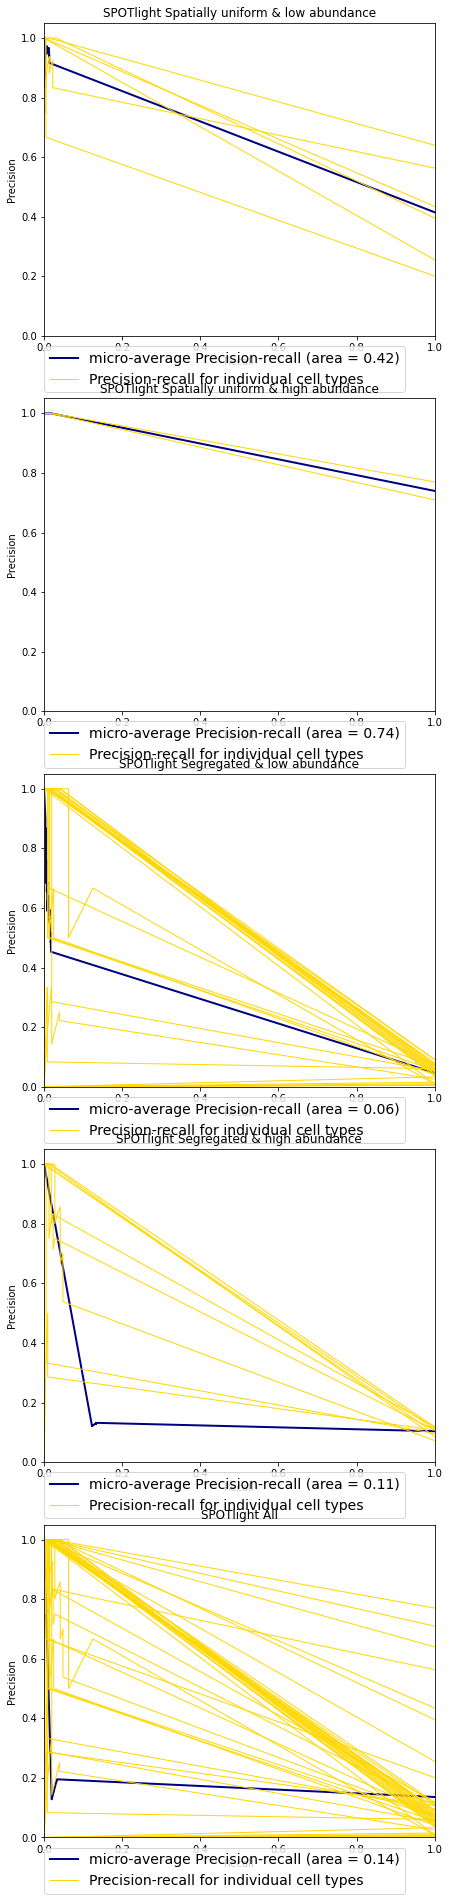

In [111]:
rcParams['figure.figsize'] = 7, 40
pos_cell_count = cell_count.values > 0
pr_by_category(pos_cell_count, spotlight_df, design,
                 nrow=5, ncol=1,
                      title='SPOTlight',
               fig_path=fig_path)

plt.savefig(os.path.split(spotlight_path_1)[0] + '/spotlightROC_all.pdf')

## Compare per-spot accuracy of cell2location and stereoscope

### Compare the stereoscope and our model using precision-recall

In [112]:
import matplotlib as mpl
from matplotlib import pyplot as plt

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']
seaborn_colors
sc.pl.palettes.default_102

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.18),
                             colors=sc.pl.palettes.default_102):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                    infer_cell_proportions[i])
        l, = plt.plot(recall["micro"], precision["micro"], color=color, lw=3)
        lines.append(l)
        
        labels.append(method_title[i] + ' (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))
        roc[method_title[i]] = average_precision["micro"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc
    
def read_cell_maps(results_folder, run_name, cell_count, post_type='mean'):
    
    # read anndata object, extract data
    sp_data_file = results_folder + run_name + '/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)
    
    # read pickle with extra info
    file = results_folder + run_name+'/model_.p'
    r = pickle.load(file = open(file, "rb"))
    
    # extract data
    from re import sub
    cell_count_columns = [sub('ref_', '', i) for i in cell_count.columns]

    spot_factors = adata_vis_res.obs[[post_type + '_spot_factors' + i for i in cell_count_columns]]
    spot_factors.columns =  ['ref_' + sub(post_type + '_spot_factors', '', i) for i in spot_factors.columns]

    #spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
    #spot_factors_sd.columns =  ['ref_' + sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

    nUMI_factors = adata_vis_res.obs[[post_type + '_nUMI_factors' + i for i in cell_count_columns]]
    nUMI_factors.columns =  [sub(post_type + '_nUMI_factors', 'ref_', i) for i in nUMI_factors.columns]
    
    #spot_factors = spot_factors / spot_factors_sd

    infer_cell_count = spot_factors[cell_count.columns]
    infer_nUMI_count = nUMI_factors[cell_count.columns]
    
    infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    return r['model_name'], infer_cell_proportions, infer_cell_count, infer_nUMI_count # spot_factors_sd

In [113]:
names = []
results = []
names_count = []
results_count = []
results_q05 = []
results_count_q05 = []

run_names = [
    'LocationModel_1experiments_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelLinearDependentW_46clusters_2000locations_12281genes_defaults_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelPyro_46clusters_2000locations_12281genes_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01_gl2',
    'LocationModelLinearDependentWPyro_46clusters_2000locations_12281genes_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01_gl2',
            ]

for n in run_names:
    name, infer_cell_prop, infer_cell_count, infer_nUMI_count = \
    read_cell_maps(results_folder, n, cell_count, post_type='mean')
    #infer_cell_count = (infer_cell_count.T / infer_cell_count.max(1)).T
    names.append(name)
    results.append(infer_cell_prop)
    names_count.append(name)
    results_count.append(infer_cell_count)
    
    name, infer_cell_prop, infer_cell_count, infer_nUMI_count = \
    read_cell_maps(results_folder, n, cell_count, post_type='q05')
    #infer_cell_count = (infer_cell_count.T / infer_cell_count.max(1)).T
    results_q05.append(infer_cell_prop)
    results_count_q05.append(infer_cell_count)

# add stereoscope
results.append(stereo_df[cell_count.columns])
results_count.append(stereo_df[cell_count.columns])
results_q05.append(stereo_df[cell_count.columns])
results_count_q05.append(stereo_df[cell_count.columns])
names.append('Stereoscope 5000 HVG')

# add RCTD_df
results.append(RCTD_df[cell_count.columns])
results_count.append(RCTD_df[cell_count.columns])
results_q05.append(RCTD_df[cell_count.columns])
results_count_q05.append(RCTD_df[cell_count.columns])
names.append('RCTD')

# add Seurat 3
results.append(seurat_df[cell_count.columns])
results_count.append(seurat_df[cell_count.columns])
results_q05.append(seurat_df[cell_count.columns])
results_count_q05.append(seurat_df[cell_count.columns])
names.append('Seurat 3 PCA')

# add Seurat 3
results.append(seurat_cca_df[cell_count.columns])
results_count.append(seurat_cca_df[cell_count.columns])
results_q05.append(seurat_cca_df[cell_count.columns])
results_count_q05.append(seurat_cca_df[cell_count.columns])
names.append('Seurat 3 CCA')

# add SPOTlight
results.append(spotlight_df[cell_count.columns])
results_count.append(spotlight_df[cell_count.columns])
results_q05.append(spotlight_df[cell_count.columns])
results_count_q05.append(spotlight_df[cell_count.columns])
names.append('SPOTlight')

# add NNLS
results.append(nnls_df[cell_count.columns])
results_count.append(nnls_df[cell_count.columns])
results_q05.append(nnls_df[cell_count.columns])
results_count_q05.append(nnls_df[cell_count.columns])
names.append('NNLS')

In [114]:
for i, n in enumerate(names):
    if (type(n) is not str) and (type(n) is not type(None)):
        names[i] = n.__name__
    elif (type(n) is type(None)):
        names[i] = 'LocationModelLinearDependentW'
        
    if n == 'LocationModelNB4V7_V4_V4':
         names[i] = 'LocationModel'
            
    if n == 'CoLocationModelNB4V2':
         names[i] = 'LocationModelLinearDependentW'
            
names

['LocationModel',
 'LocationModelLinearDependentW',
 'LocationModelPyro',
 'LocationModelLinearDependentWPyro',
 'Stereoscope 5000 HVG',
 'RCTD',
 'Seurat 3 PCA',
 'Seurat 3 CCA',
 'SPOTlight',
 'NNLS']

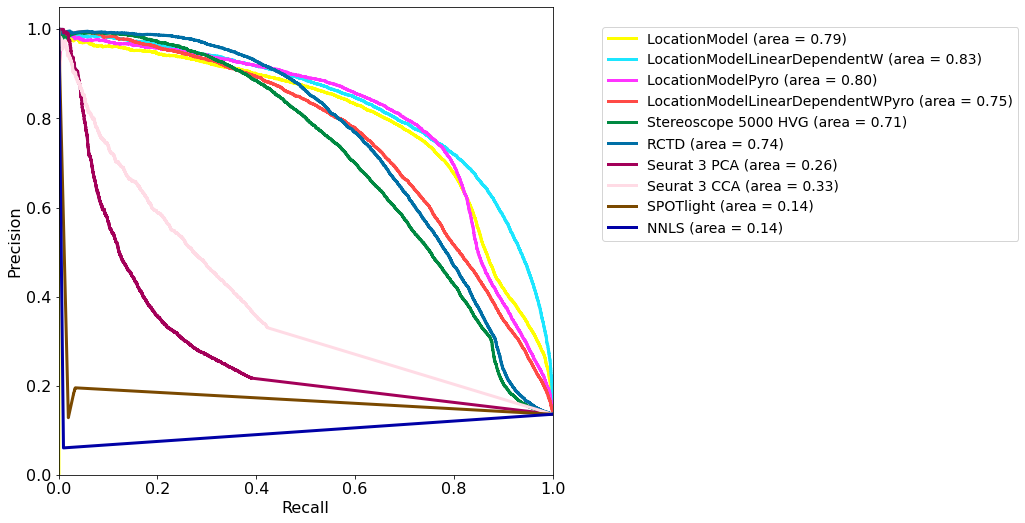

In [115]:
rcParams['figure.figsize'] = 15, 8
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, results,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_all.pdf')

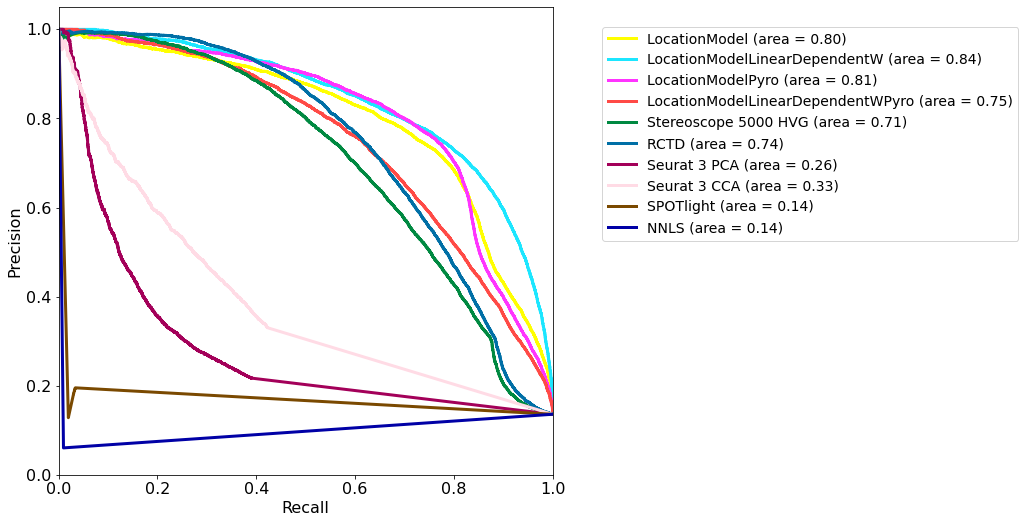

In [116]:
rcParams['figure.figsize'] = 15, 8
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, results_count,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_all_count.pdf')

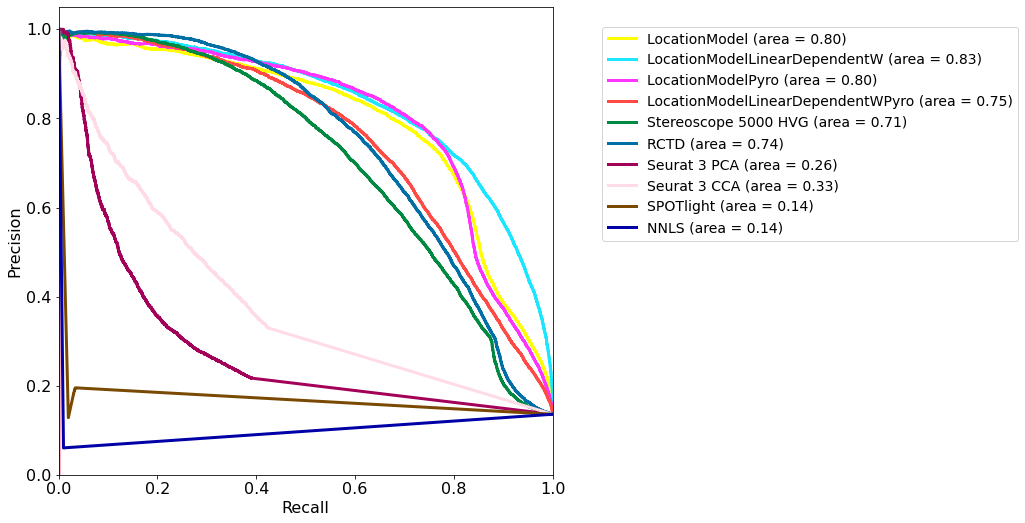

In [117]:
rcParams['figure.figsize'] = 15, 8
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, results_q05,
                         method_title=names, 
                         legend_loc=(1.1, 0.5))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_q05_all.pdf')

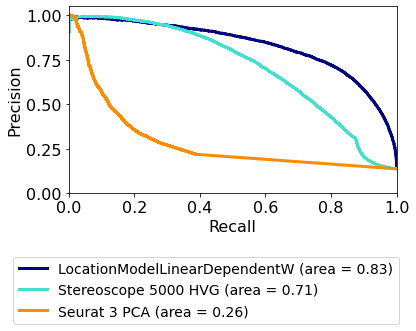

In [121]:
rcParams['figure.figsize'] = 6,5.5 
rcParams['font.size'] = 16

compare_precision_recall(pos_cell_count, [results[i] for i in [1, 4, 6]],
                         method_title=[names[i] for i in [1, 4, 6]],
                         legend_loc=(-0.17, -0.7),
                         colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected.pdf')

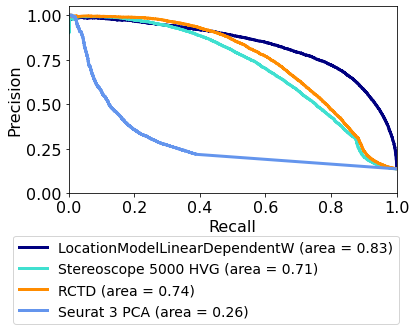

In [122]:
rcParams['figure.figsize'] = 6,5.5 
rcParams['font.size'] = 16

compare_precision_recall(pos_cell_count, [results[i] for i in [1, 4, 5, 6]],
                         method_title=[names[i] for i in [1, 4, 5, 6]],
                         legend_loc=(-0.17, -0.7),
                         colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected_rctd.pdf')

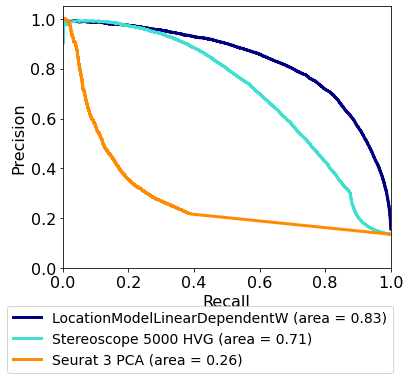

In [123]:
rcParams['figure.figsize'] = 6,5.5 
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, [results_q05[i] for i in [1, 4, 6]],
                         method_title=[names[i] for i in [1, 4, 6]],
                         legend_loc=(-0.17, -0.4),
                         colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_q05_selected.pdf')

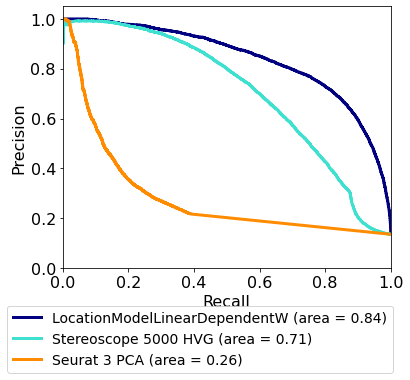

In [124]:
rcParams['figure.figsize'] = 6,5.5 
rcParams['font.size'] = 16

compare_precision_recall(pos_cell_count, [results_count[i] for i in [1, 4, 6]],
                         method_title=[names[i] for i in [1, 4, 6]],
                         legend_loc=(-0.17, -0.4),
                         colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected_count.pdf')

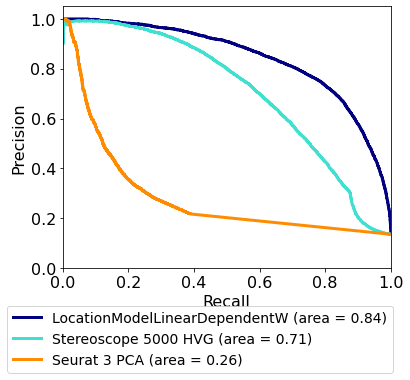

In [125]:
rcParams['figure.figsize'] = 6,5.5 
rcParams['font.size'] = 16
compare_precision_recall(pos_cell_count, [results_count_q05[i] for i in [1, 4, 6]],
                         method_title=[names[i] for i in [1, 4, 6]],
                         legend_loc=(-0.17, -0.4),
                         colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_q05_selected_count.pdf')

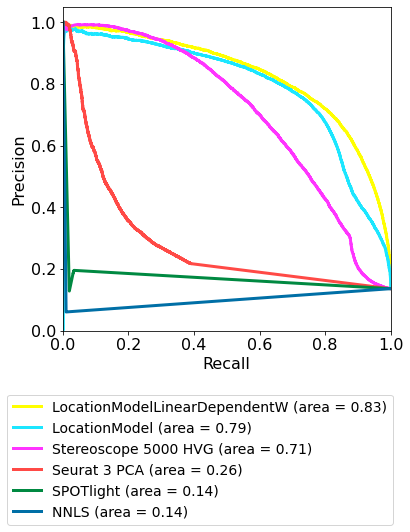

In [126]:
rcParams['figure.figsize'] = 6,8
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentW',
             'LocationModel',
             'Stereoscope 5000 HVG',
             'Seurat 3 PCA',
             'SPOTlight',
             'NNLS'
            ]

results_dict = {}
for i, n in enumerate(names):
    results_dict[n] = results[i]

results_dict_sel = {}
for i, n in enumerate(mod_names):
    results_dict_sel[n] = results_dict[n]

compare_precision_recall(pos_cell_count, list(results_dict_sel.values()),
                         method_title=list(results_dict_sel.keys()),
                         legend_loc=(-0.17, -0.6))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected_FigS2.pdf')

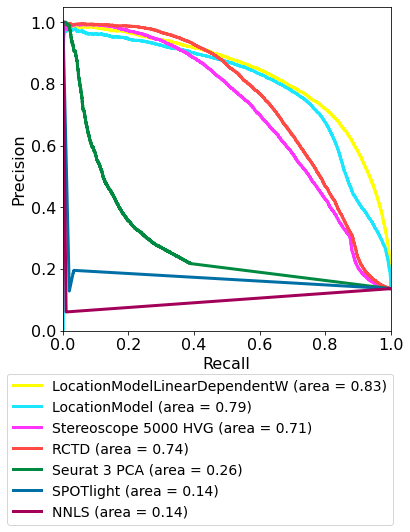

In [128]:
rcParams['figure.figsize'] = 6,8
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentW',
             'LocationModel',
             'Stereoscope 5000 HVG',
             'RCTD',
             'Seurat 3 PCA',
             'SPOTlight',
             'NNLS'
            ]

results_dict = {}
for i, n in enumerate(names):
    results_dict[n] = results[i]

results_dict_sel = {}
for i, n in enumerate(mod_names):
    results_dict_sel[n] = results_dict[n]

compare_precision_recall(pos_cell_count, list(results_dict_sel.values()),
                         method_title=list(results_dict_sel.keys()),
                         legend_loc=(-0.17, -0.6))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected_rctd_FigS2.pdf')

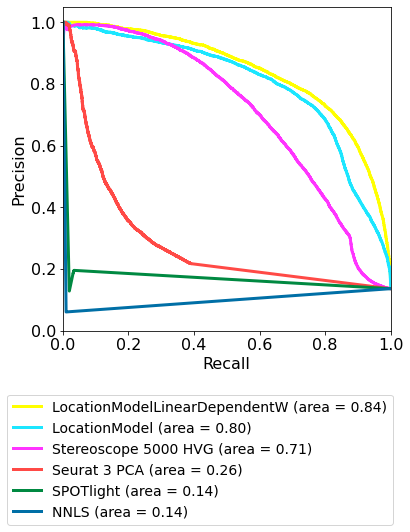

In [127]:
rcParams['figure.figsize'] = 6,8
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentW',
             'LocationModel',
             'Stereoscope 5000 HVG',
             'Seurat 3 PCA',
             'SPOTlight',
             'NNLS'
            ]

results_count_dict = {}
for i, n in enumerate(names):
    results_count_dict[n] = results_count[i]

results_count_dict_sel = {}
for i, n in enumerate(mod_names):
    results_count_dict_sel[n] = results_count_dict[n]

compare_precision_recall(pos_cell_count, list(results_count_dict_sel.values()),
                         method_title=list(results_count_dict_sel.keys()),
                         legend_loc=(-0.17, -0.6))
plt.tight_layout()
plt.savefig(fig_path + '/ROC_comparison_selected_count_FigS2.pdf')

#### Compares using RMSE on proportions

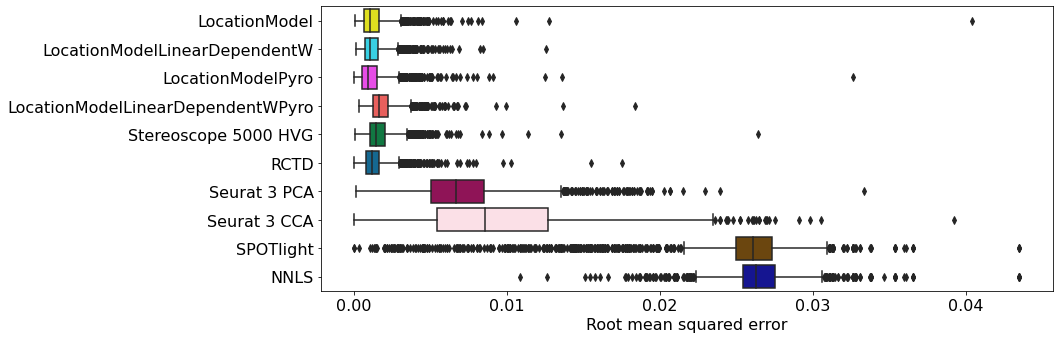

In [129]:
from sklearn.metrics import mean_squared_error
rmse = pd.DataFrame()
for i in range(len(results)):
    rmse[names[i]] = ((cell_proportions - results[i]) ** 2).mean(1)

rcParams['figure.figsize'] = 15, 5
sns.boxplot(data=rmse, orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison_all.pdf')
plt.show()

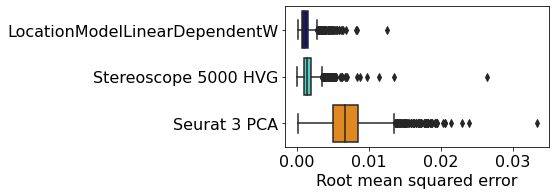

In [130]:
rcParams['figure.figsize'] = 8, 3
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentW',
             'Stereoscope 5000 HVG',
             'Seurat 3 PCA']

from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
my_palette = dict(zip(mod_names, colors))

sns.boxplot(data=rmse[mod_names], orient="h", palette=my_palette).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison_selected.pdf')
plt.show()

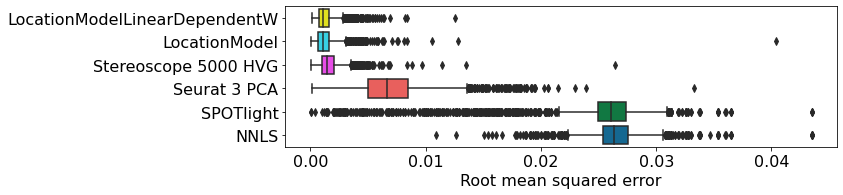

In [131]:
rcParams['figure.figsize'] = 12, 3
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentW',
             'LocationModel',
             'Stereoscope 5000 HVG',
             'Seurat 3 PCA',
             'SPOTlight',
             'NNLS'
            ]

sns.boxplot(data=rmse[mod_names], orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison_selected_FigS2.pdf')
plt.show()

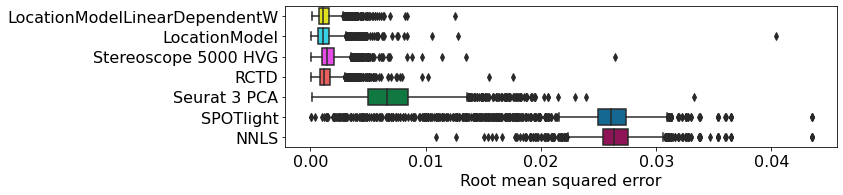

In [132]:
rcParams['figure.figsize'] = 12, 3
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 16

mod_names = ['LocationModelLinearDependentW',
             'LocationModel',
             'Stereoscope 5000 HVG',
             'RCTD',
             'Seurat 3 PCA',
             'SPOTlight',
             'NNLS'
            ]

sns.boxplot(data=rmse[mod_names], orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_comparison_selected_rctd_FigS2.pdf')
plt.show()

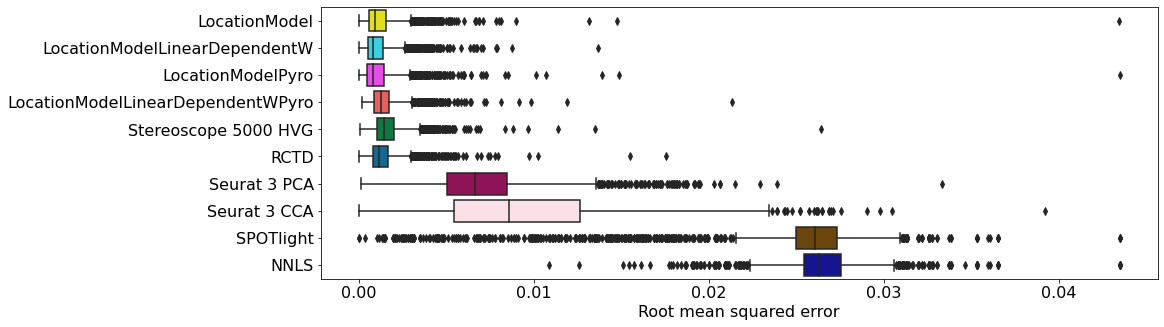

In [133]:
rmse_q05 = pd.DataFrame()
for i in range(len(results)):
    rmse_q05[names[i]] = ((cell_proportions - results_q05[i]) ** 2).mean(1)
    
rcParams['figure.figsize'] = 15, 5
sns.boxplot(data=rmse_q05, orient="h", palette=sc.pl.palettes.default_102).set(
    xlabel='Root mean squared error'
)
plt.show()

## Investigate the robustness of models to sensitivity

In [131]:
names = []
results = []
names_count = []
results_count = []
results_q05 = []
results_count_q05 = []

results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/lowdens_synthetic_ST_fewcells/samples_2/'

run_names = [
    # varying levels of downsampling (1, 2, 4, 8)
    'CoLocationModelNB4V2_46clusters_2000locations_12281genes_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01_gl1',
    'CoLocationModelNB4V2_46clusters_2000locations_12281genes_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01',
    'CoLocationModelNB4V2_46clusters_2000locations_12281genes_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01_gl4',
    'CoLocationModelNB4V2_46clusters_2000locations_12281genes_n_comb60_lr0005_n_iter30k_mean_var5_ceps9_cps4_fps5_inf_shape01_gl8',
            ]

for n in run_names:
    name, infer_cell_prop, infer_cell_count, _ = \
    read_cell_maps(results_folder + 'models/', n, cell_count, post_type='mean')
    names.append(name)
    results.append(infer_cell_prop)
    names_count.append(name)
    results_count.append(infer_cell_count)
    
    name, infer_cell_prop, infer_cell_count, _ = \
    read_cell_maps(results_folder + 'models/', n, cell_count, post_type='q05')
    results_q05.append(infer_cell_prop)
    results_count_q05.append(infer_cell_count)

# add stereoscope
stereo_run_names = [
    # varying levels of downsampling (1, 2, 4, 8)
    'Stereoscope, 1',
    'Stereoscope, 2',
    'Stereoscope, 4',
    'Stereoscope, 8',
            ]

stereo_paths = [
    # varying levels of downsampling (1, 2, 4, 8)
    f'{results_folder}stereoscope/run_sp_data_downsampled1/sp_data_downsampled1/W.2020-07-14173407.710471.tsv',
    f'{results_folder}stereoscope/run_sp_data_downsampled/sp_data_downsampled/W.2020-07-03143613.779408.tsv',
    f'{results_folder}stereoscope/run_sp_data_downsampled4/sp_data_downsampled4/W.2020-07-14173407.650388.tsv',
    f'{results_folder}stereoscope/run_sp_data_downsampled8/sp_data_downsampled8/W.2020-07-14173407.646800.tsv',
            ]

from re import sub
for n in range(len(stereo_run_names)):

    stereo_df = pd.read_csv(stereo_paths[n], sep='\t', index_col=0)
    if 'ref_' not in stereo_df.columns[0]:
        stereo_df.columns = [f'ref_{i}' for i in stereo_df.columns]

    stereo_df = stereo_df.loc[stereo_df.index.isin(adata_vis.obs_names)]
    results.append(stereo_df[cell_count.columns])
    results_count.append(stereo_df[cell_count.columns])
    results_q05.append(stereo_df[cell_count.columns])
    names.append(stereo_run_names[n])

# add Seurat 3
seurat_run_names = [
    # varying levels of downsampling (1, 2, 4, 8)
    'Seurat 3, 1',
    'Seurat 3, 2',
    'Seurat 3, 4',
    'Seurat 3, 8',
            ]

seurat_paths = [
    # varying levels of downsampling (1, 2, 4, 8)
    f'{results_folder}seurat/dowsampled1_seurat_pca_seed{seed_numbers}.csv',
    f'{results_folder}seurat/dowsampled_seurat_pca_seed{seed_numbers}.csv',
    f'{results_folder}seurat/dowsampled4_seurat_pca_seed{seed_numbers}.csv',
    f'{results_folder}seurat/dowsampled8_seurat_pca_seed{seed_numbers}.csv',
            ]


for n in range(len(seurat_run_names)):
    # read cell proportions
    seurat_df = pd.read_csv(seurat_paths[n], sep=',', index_col='spot')
    seurat_df = seurat_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
    
    seurat_df.columns = [sub('prediction.score.', '', i) for i in seurat_df.columns]
    if 'ref_' not in seurat_df.columns[0]:
        seurat_df.columns = [f'ref_{i}' for i in seurat_df.columns]
        
    # compute proportions per location
    seurat_df = (seurat_df.T / seurat_df.sum(1)).T

    seurat_df = seurat_df.loc[seurat_df.index.isin(adata_vis.obs_names)]

    results.append(seurat_df[cell_count.columns])
    results_count.append(seurat_df[cell_count.columns])
    results_q05.append(seurat_df[cell_count.columns])
    names.append(seurat_run_names[n])

In [132]:
names[0] = names[0] + ', 1'
names[1] = names[1] + ', 2'
names[2] = names[2] + ', 4'
names[3] = names[3] + ', 8'

names

['CoLocationModelNB4V2, 1',
 'CoLocationModelNB4V2, 2',
 'CoLocationModelNB4V2, 4',
 'CoLocationModelNB4V2, 8',
 'Stereoscope, 1',
 'Stereoscope, 2',
 'Stereoscope, 4',
 'Stereoscope, 8',
 'Seurat 3, 1',
 'Seurat 3, 2',
 'Seurat 3, 4',
 'Seurat 3, 8']

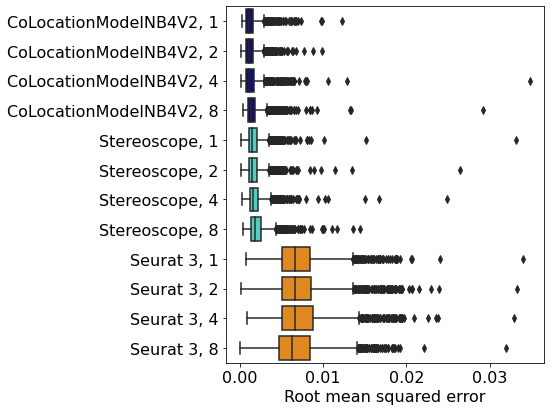

In [133]:
rcParams['figure.figsize'] = 8, 6
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 16

from sklearn.metrics import mean_squared_error
rmse = pd.DataFrame()
for i in range(len(results)):
    rmse[names[i]] = ((cell_proportions - results[i]) ** 2).mean(1)

colors = np.repeat(['navy', 'turquoise', 'darkorange'], 4)
my_palette = {names[n]: colors[n] for n in range(len(names))}

sns.boxplot(data=rmse, orient="h", palette=my_palette).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.savefig(fig_path + '/RMSE_decreasing_sensitivity.pdf')
plt.show()

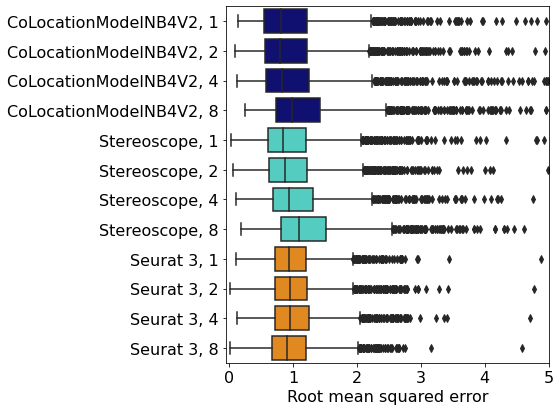

CoLocationModelNB4V2, 1    0.001299
CoLocationModelNB4V2, 2    0.001282
CoLocationModelNB4V2, 4    0.001381
CoLocationModelNB4V2, 8    0.001589
Stereoscope, 1             0.001675
Stereoscope, 2             0.001699
Stereoscope, 4             0.001842
Stereoscope, 8             0.002119
Seurat 3, 1                0.006984
Seurat 3, 2                0.007163
Seurat 3, 4                0.007237
Seurat 3, 8                0.006864
dtype: float64

In [134]:
rmse_mean = rmse.mean(0)

rmse.loc[:, ['CoLocationModelNB4V2' in i for i in rmse.columns]] =\
rmse.loc[:, ['CoLocationModelNB4V2' in i for i in rmse.columns]] \
/ rmse_mean['CoLocationModelNB4V2, 1']

rmse.loc[:, ['Stereoscope' in i for i in rmse.columns]] =\
rmse.loc[:, ['Stereoscope' in i for i in rmse.columns]] \
/ rmse_mean['Stereoscope, 1']

rmse.loc[:, ['Seurat 3' in i for i in rmse.columns]] =\
rmse.loc[:, ['Seurat 3' in i for i in rmse.columns]] \
/ rmse_mean['Seurat 3, 1']

colors = np.repeat(['navy', 'turquoise', 'darkorange'], 4)
my_palette = {names[n]: colors[n] for n in range(len(names))}

sns.boxplot(data=rmse, orient="h", palette=my_palette).set(
    xlabel='Root mean squared error'
)
plt.tight_layout()
plt.xlim(-0.05, 5)
plt.savefig(fig_path + '/RMSE_decreasing_sensitivity.pdf')
plt.show()

rmse_mean

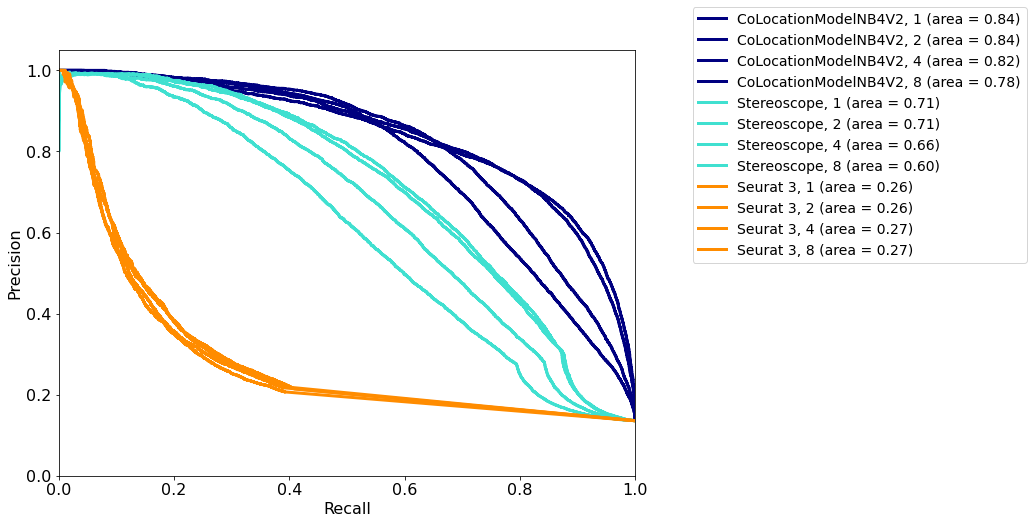

In [135]:
rcParams['figure.figsize'] = 15, 8
rcParams['font.size'] = 16
roc = compare_precision_recall(pos_cell_count, results_count,
                         method_title=names, 
                         legend_loc=(1.1, 0.5),
                         colors=my_palette.values())
plt.tight_layout()
plt.savefig(fig_path + '/ROC_decreasing_sensitivity.pdf')

In [136]:
roc = pd.DataFrame(roc, index=['ROC']).T
roc['model'] = [sub(', .$', '', i) for i in roc.index]
roc['sensitivity'] = [sub('^.+, ', '', i) for i in roc.index]
roc = roc.pivot_table(index=['model'], columns=['sensitivity']).fillna(0).T
roc.index = [i[1] for i in roc.index.values]

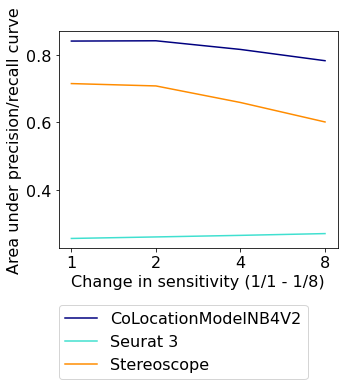

In [137]:
rcParams['figure.figsize'] = 5, 4
rcParams['font.size'] = 16
plt.plot(roc.iloc[:,0], color=['navy', 'turquoise', 'darkorange'][0]);
plt.plot(roc.iloc[:,1], color=['navy', 'turquoise', 'darkorange'][1]);
plt.plot(roc.iloc[:,2], color=['navy', 'turquoise', 'darkorange'][2]);
plt.xlabel('Change in sensitivity (1/1 - 1/8)');
plt.ylabel('Area under precision/recall curve');
plt.legend(roc.columns, loc=(0,-0.6));

In [138]:
corrcoef = {}
for n in range(len(names)):
    corrcoef[names[n]] = np.corrcoef(results[n].values.flatten(), cell_proportions.values.flatten())[0,1]
corrcoef = pd.DataFrame(corrcoef, index=['cor']).T

corrcoef['model'] = [sub(', .$', '', i) for i in corrcoef.index]
corrcoef['sensitivity'] = [sub('^.+, ', '', i) for i in corrcoef.index]
corrcoef = corrcoef.pivot_table(index=['model'], columns=['sensitivity']).fillna(0).T
corrcoef.index = [i[1] for i in corrcoef.index.values]

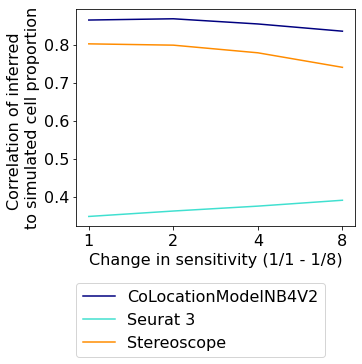

In [139]:
rcParams['figure.figsize'] = 5, 4
rcParams['font.size'] = 16
plt.plot(corrcoef.iloc[:,0], color=['navy', 'turquoise', 'darkorange'][0]);
plt.plot(corrcoef.iloc[:,1], color=['navy', 'turquoise', 'darkorange'][1]);
plt.plot(corrcoef.iloc[:,2], color=['navy', 'turquoise', 'darkorange'][2]);
plt.xlabel('Change in sensitivity (1/1 - 1/8)');
plt.ylabel('Correlation of inferred \nto simulated cell proportion');
plt.legend(corrcoef.columns, loc=(0,-0.6));